In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import nltk  #https://github.com/cjhutto/vaderSentiment
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk import FreqDist
import string
from wordcloud import WordCloud
lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS
nltk.download('omw-1.4')
import numpy as np
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import re
from collections import Counter
from time import time
%matplotlib inline
# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import sys
import torch
from sklearn import model_selection
import math
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from datasketch import MinHash, MinHashLSHForest

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Paulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Reading and combining the datasets

In [2]:
data1=pd.read_csv('articles1.csv',index_col=0)
data2=pd.read_csv('articles2.csv',index_col=0)
data3=pd.read_csv('articles3.csv',index_col=0)
data=pd.concat([data1,data2,data3])

In [3]:
data.describe(include=["object", "bool"]) # Description of the dataframe

,count,unique,top,freq
title,142568,142132,,12
publication,142570,15,Breitbart,23781
author,126694,15647,Breitbart News,1559
date,139929,1646,2017-02-03,402
url,85559,85559,https://web.archive.org/web/20160101000951/htt...,1
content,142570,142038,advertisement,42


There are several rows that contain only 'advertisement' so we are going to drop them.

In [28]:
print(len(data))
data['content']=data['content'].str.lower()
data=data[data['content'].str.contains('advertisement')==False]
print(len(data))

142570
141590


Now, we will extract the top 30 most frequent authors.

In [29]:
top_30=data.groupby('author').count().sort_values(by='title',ascending=False)[0:30].reset_index()
top_30_list=list(top_30['author'])
data_top_30=data[data['author'].isin(top_30_list)]
data_top_30.to_csv('Top30.csv')

# Jaccard Similarity

In [ ]:
data = pd.read_csv('top30.csv')
data['lenght']=data['content'].apply(len)
data=data.sort_values(by='lenght',ascending=False)[4:]
data = data[data['author']!='Breitbart News']
names = data.author.value_counts().index.tolist()
minarticles = data.author[data.author == names[-1]].value_counts()
#names.remove('Breitbart News')

In [ ]:
#Preprocess split a text into individual tokens based on whitespace.
def preprocess(text):
    text = re.sub(r'[^\w\s]','',text)
    tokens = text.lower()
    tokens = tokens.split()
    return tokens

In [ ]:
def get_forest(data, perms):    
    #A mapping of the whole dataset as minhashes so it is stored and it can be used with different purposes
    minhash = []
    for text in data['content']:
        tokens = preprocess(text)
        m = MinHash(num_perm=perms)
        for s in tokens:
            m.update(s.encode('utf8'))
        minhash.append(m)
        
    forest = MinHashLSHForest(num_perm=perms)
    
    for i,m in enumerate(minhash):
        forest.add(i,m)
    #So the indices are searchable:
    forest.index()    
    return forest

In [ ]:
permutations = 128
forest = get_forest(data,permutations)

In [ ]:
def get_minhash(text):
        #list of minhash for the input text
        minhash1 = []
        #list of minhash for the text to be compared
        minhash2 = []
        #dict that will store the name of the document plus the Jaccard Similarity
        similarity = {}
        
        tokens1 = preprocess(text)
        m1 = MinHash(num_perm=128)
        for s in tokens1:
            m1.update(s.encode('utf8'))
        minhash1.append(m1)
        #getting the indices of the top 5 articles by Jaccard Similarity (if the input article is from the the same dataset the top 1 will be itself)
        result =forest.query(m1, 5)
        for item in result:
            tokens = preprocess(data.content[item])
            m2 = MinHash(num_perm=128)
            for t in tokens:
                m2.update(t.encode('utf8'))
            minhash2.append(m2)
            #key with the Title and value with the Jaccard Similarity
            similarity[data.title[item]] = m1.jaccard(m2)
        return similarity

In [ ]:
data['jaccard_sim']= data.content.apply(get_minhash)

In [ ]:
#Example of the top 5 articles by Jaccard Similarity, 
data.jaccard_sim.iloc[0]

{'DNC Chair Brazile: Hillary Speech Leaks ’Crap’ Postmarked From Russia - Breitbart': 0.125,
 'Arianna Huffington: Trump ’a Clear and Present Danger’ - Breitbart': 0.9765625,
 'Carl Bernstein: Trump Has ’Lied as No President of the United States in My Lifetime Has’ - Breitbart': 0.3203125,
 '‘The View’ Co-host Joy Behar: Trump Is ‘The Most Dangerous Man Alive’ - Breitbart': 0.203125,
 'Arianna Huffington: Trump Is Like Kim Jong-un - ’Dangerous,’ ’a Buffoon’ - Breitbart': 1.0}

In [ ]:
data[data['title']=='Arianna Huffington: Trump ’a Clear and Present Danger’ - Breitbart']['content']

16269    Sunday on CNN’s “Reliable Sources,” the   and ...
Name: content, dtype: object

In [ ]:
data[data['title']=='Arianna Huffington: Trump Is Like Kim Jong-un - ’Dangerous,’ ’a Buffoon’ - Breitbart']['content']

16345    Sunday on CNN’s “Reliable Sources,” Arianna Hu...
Name: content, dtype: object

### Data Visualization

In [2]:
data1=pd.read_csv('articles1.csv',index_col=0)
data2=pd.read_csv('articles2.csv',index_col=0)
data3=pd.read_csv('articles3.csv',index_col=0)
data=pd.concat([data1,data2,data3])

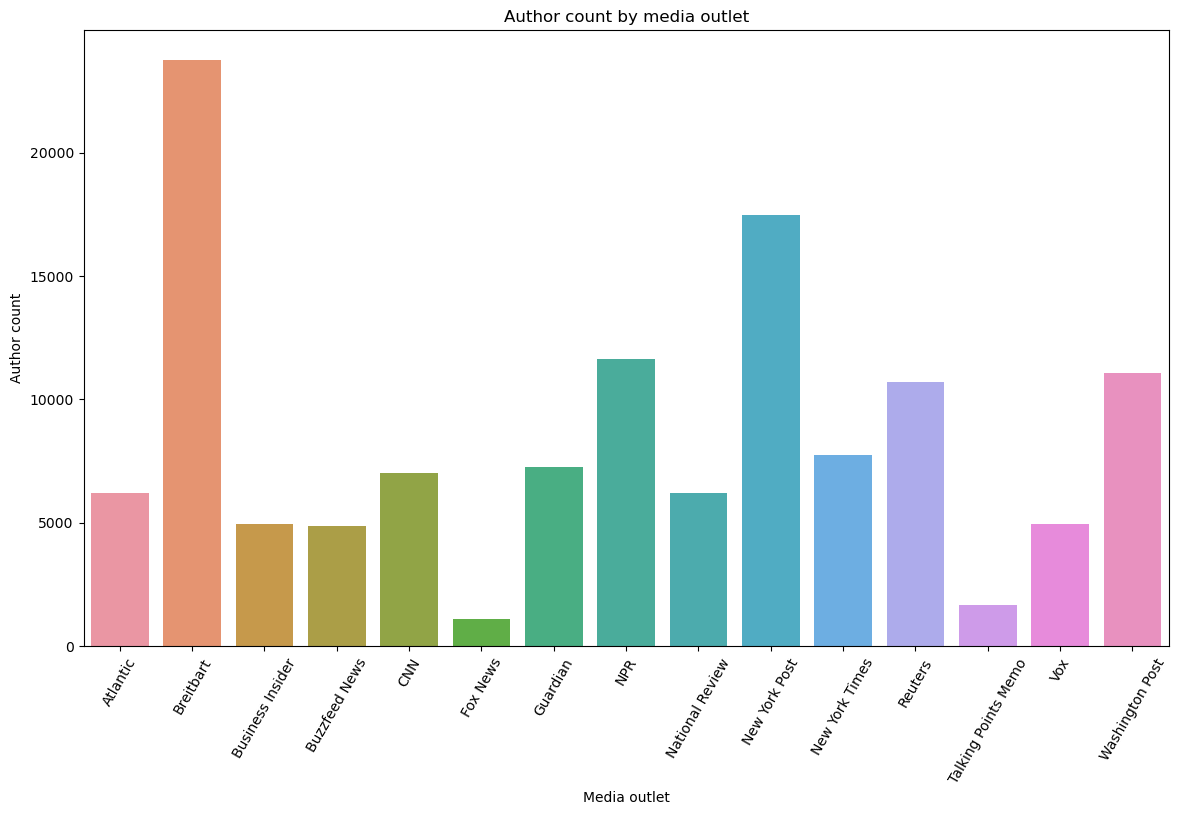

In [5]:
group=data.groupby('publication').count()
plt.figure(figsize=(14,8))
ax=sns.barplot(data=group, x=group.index, y='author')
ax.tick_params(axis='x', rotation=60)
ax.set_title('Author count by media outlet')
ax.set_ylabel('Author count', fontsize='medium')
ax.set_xlabel('Media outlet', fontsize='medium')
plt.show()

Now, we'll calculate the lenght of each article and visualize it.

In [7]:
data['lenght']=data['content'].str.len() # Get lenght of article

Text(0, 0.5, 'Mean lenght')

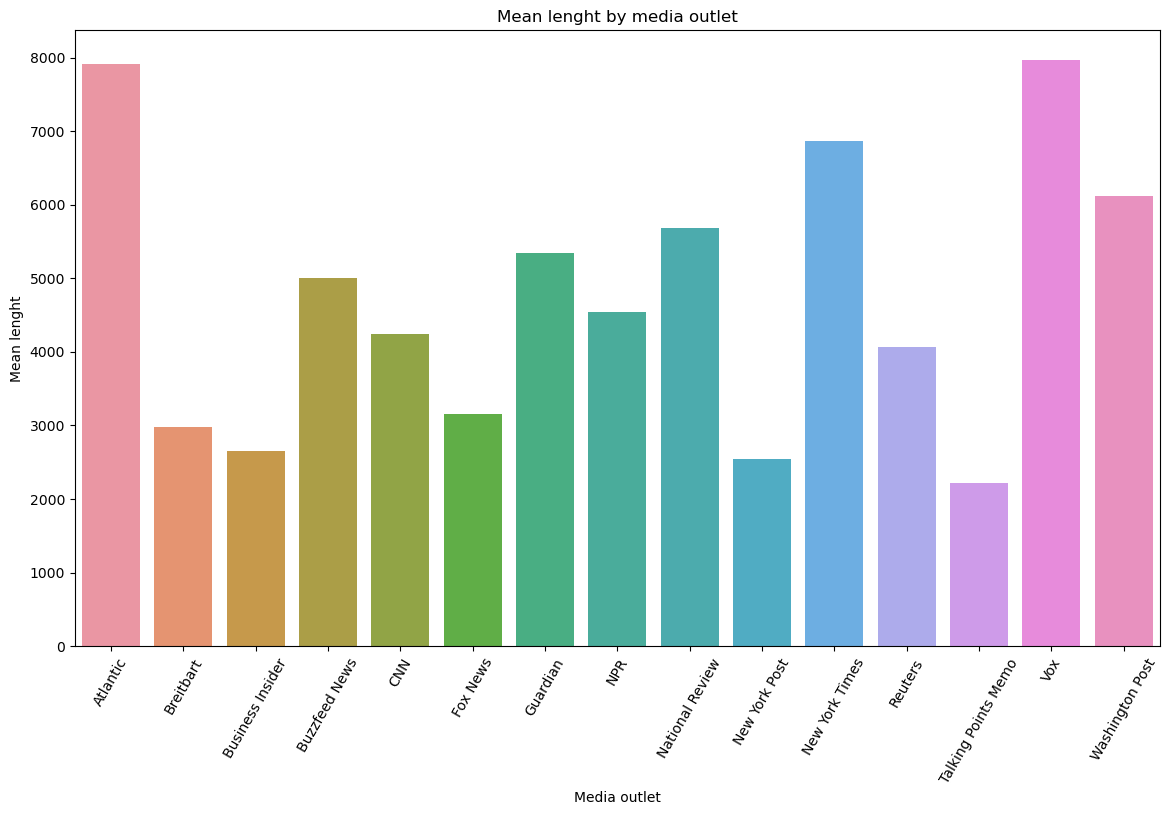

In [8]:
group2=data.groupby('publication').mean() # Group by media outlet
plt.figure(figsize=(14,8))
ax=sns.barplot(data=group2, x=group.index, y='lenght')
ax.tick_params(axis='x', rotation=60)
ax.set_title('Mean lenght by media outlet')
ax.set_xlabel('Media outlet', fontsize='medium')
ax.set_ylabel('Mean lenght', fontsize='medium')

We can clearly see that the amount of authors and mean lenght varies greatly by each publication.

# Classifications by lenght, TF-IDF & TF

In [ ]:
data = pd.read_csv('top30.csv')
data['lenght']=data['content'].apply(len)
data=data.sort_values(by='lenght',ascending=False)[4:]
data = data[data['author']!='Breitbart News']
names = data.author.value_counts().index.tolist()
minarticles = data.author[data.author == names[-1]].value_counts()
#names.remove('Breitbart News')

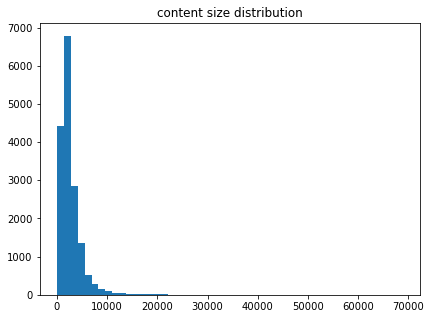

In [ ]:
fig = plt.figure(figsize=(15, 5));
sub1 = plt.subplot(121)
plt.title("content size distribution") #Over all
data.lenght.hist( bins=50,grid=False);

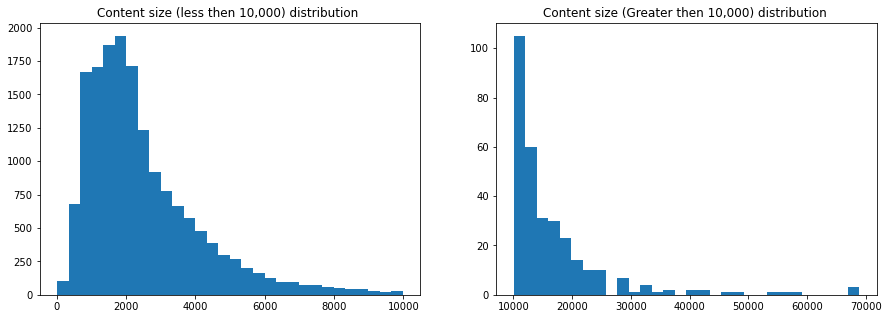

In [ ]:
fig = plt.figure(figsize=(15, 5));
sub1 = plt.subplot(121)
plt.title("Content size (less then 10,000) distribution ") #Over all
data[data['lenght']<10000].lenght.hist(bins=30,grid=False);

sub2 = plt.subplot(122)
plt.title("Content size (Greater then 10,000) distribution ") #less then 10,000 text length
data[data['lenght']>10000].lenght.hist(bins=30,grid=False);

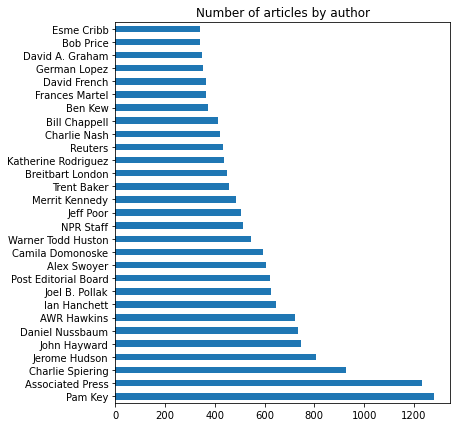

In [ ]:
fig = plt.figure(figsize=(6, 7))
plt.title("Number of articles by author") 
data.author.value_counts().plot(kind='barh');

## Cleaning / Pre processing content


In [ ]:

lemmatizer = WordNetLemmatizer()
Stop_Words= _stop_words.ENGLISH_STOP_WORDS

def text_processing(text):
    # Remove URL and its punctuation , and @
    text = re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split() 
                     if w not in Stop_Words])
    # Stemming
    #stemmer = PorterStemmer()
    #text = " ".join([stemmer.stem(w1) for w1 in text.split()])
    
    # lematizing 
    text = " ".join([lemmatizer.lemmatize(w2) for w2 in text.split()])
    return text

In [ ]:
data['clean_content'] = data['content'].apply(text_processing)

In [ ]:
print("**Original content**\n",data[['content']].head(1).values[0][0][:830],"\n\n")

print("**Cleaned content**\n",data[['clean_content']].head(1).values[0][0][:500])

**Original content**
 MIGRANT CRISIS LIVE WIRE  —   This page will host all the relevant information from Europe’s unfolding migrant crisis. You can follow all the latest updates below. [This page is edited by Breitbart London’s Raheem Kassam, Chris Tomlinson, Oliver Lane and Donna Rachel Edmunds. Newest updates will appear at the top of the page.  *      *      *      *     * A 28 year old Romanian man is in the process fo being deported and banned from Denmark for six years after he was caught stealing two  . The man had already been ejected from Denmark once before for a previous offence, and so was in Denmark illegally before he was even caught stealing. The individual will likely serve a ten day prison sentence before being expelled, reports TheLocal. A 42 year old man was arrested last night on suspicion of murder after his girlfriend 


**Cleaned content**
 migrant crisis live wire page host relevant information europe unfolding migrant crisis follow latest update page edited br

### Let's now represent the text in a format which can be used in machine learning**

In [ ]:


count_vect = CountVectorizer()
bow_counts = count_vect.fit_transform(data['clean_content'].values)

In [ ]:
print(len(count_vect.vocabulary_))

77552


In [ ]:


tf_transformer = TfidfTransformer()
bow_tfidf = tf_transformer.fit_transform(bow_counts)

### 3. Classifications

In [ ]:
X_len = data['lenght'].values
X_len = X_len.reshape(-1, 1) # Since we it is single feature
X_bow_counts = bow_counts
X_bow_tfidf = bow_tfidf

author = list(data.author)
y = []
for index in author:
    ind = names.index(index)
    y.append(ind)

labels = np.array(names)

In [ ]:
print(X_len.shape)
print(X_bow_counts.shape)
print(X_bow_tfidf.shape)
print(len(y))

(16674, 1)
(16674, 77552)
(16674, 77552)
16674


80-20 ratio train/test split. 

In [ ]:
# train/test split


rs = 42 # reproducible results, set to None for random
(X_len_train, X_len_test, X_bow_counts_train, X_bow_counts_test, 
 X_bow_tfidf_train, X_bow_tfidf_test, y_train, y_test) = train_test_split(
    X_len, X_bow_counts, X_bow_tfidf, y,
    test_size=0.2, stratify=y, random_state=rs)

In [ ]:


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # uselabels thatin the data coumns
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        1+1 # Just liuke that
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # displaty ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # labelticks
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right",
             rotation_mode="anchor")

    # make and porint text.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.rcParams["figure.figsize"] = (28,16) # as its large data
    return ax

> ### **(1) Classification using the content size**

In [ ]:


parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), parameters, cv=5) #gridsearch with 5 folds
lr.fit(X_len_train, y_train)
print(lr.best_params_)

{'C': 1e-09}


                      precision    recall  f1-score   support

             Pam Key       0.00      0.00      0.00       256
    Associated Press       0.00      0.00      0.00       246
    Charlie Spiering       0.00      0.00      0.00       186
       Jerome Hudson       0.00      0.00      0.00       161
        John Hayward       0.00      0.00      0.00       149
     Daniel Nussbaum       0.00      0.00      0.00       147
         AWR Hawkins       0.00      0.00      0.00       144
        Ian Hanchett       0.00      0.00      0.00       129
      Joel B. Pollak       0.00      0.00      0.00       125
Post Editorial Board       0.00      0.00      0.00       124
         Alex Swoyer       0.00      0.00      0.00       121
    Camila Domonoske       0.00      0.00      0.00       119
  Warner Todd Huston       0.00      0.00      0.00       109
           NPR Staff       0.00      0.00      0.00       103
           Jeff Poor       0.00      0.00      0.00       101
      M

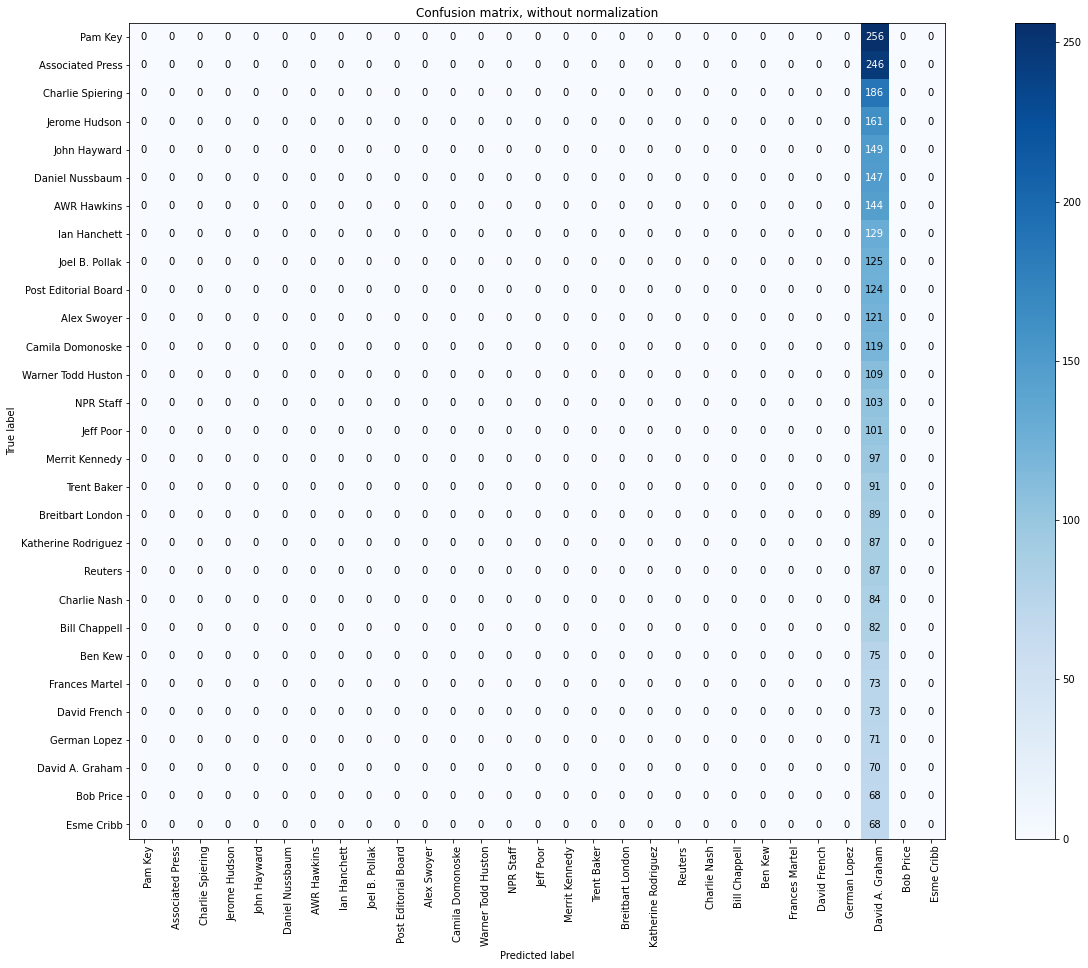

In [ ]:
y_pred = lr.predict(X_len_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)

> ### **(2) Classification using tf-idf.**

In [ ]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), parameters, cv=5) #same GSCV with 5 folds
lr.fit(X_bow_tfidf_train, y_train)
print(lr.best_params_)

{'C': 10}


                      precision    recall  f1-score   support

             Pam Key       0.99      0.95      0.97       256
    Associated Press       0.65      0.74      0.69       246
    Charlie Spiering       0.83      0.88      0.85       186
       Jerome Hudson       0.94      0.94      0.94       161
        John Hayward       0.82      0.76      0.79       149
     Daniel Nussbaum       0.90      0.96      0.93       147
         AWR Hawkins       0.99      0.99      0.99       144
        Ian Hanchett       0.99      0.98      0.99       129
      Joel B. Pollak       0.98      0.84      0.91       125
Post Editorial Board       0.89      0.88      0.89       124
         Alex Swoyer       0.84      0.90      0.87       121
    Camila Domonoske       0.66      0.61      0.64       119
  Warner Todd Huston       0.99      0.96      0.98       109
           NPR Staff       0.74      0.82      0.77       103
           Jeff Poor       1.00      0.97      0.98       101
      M

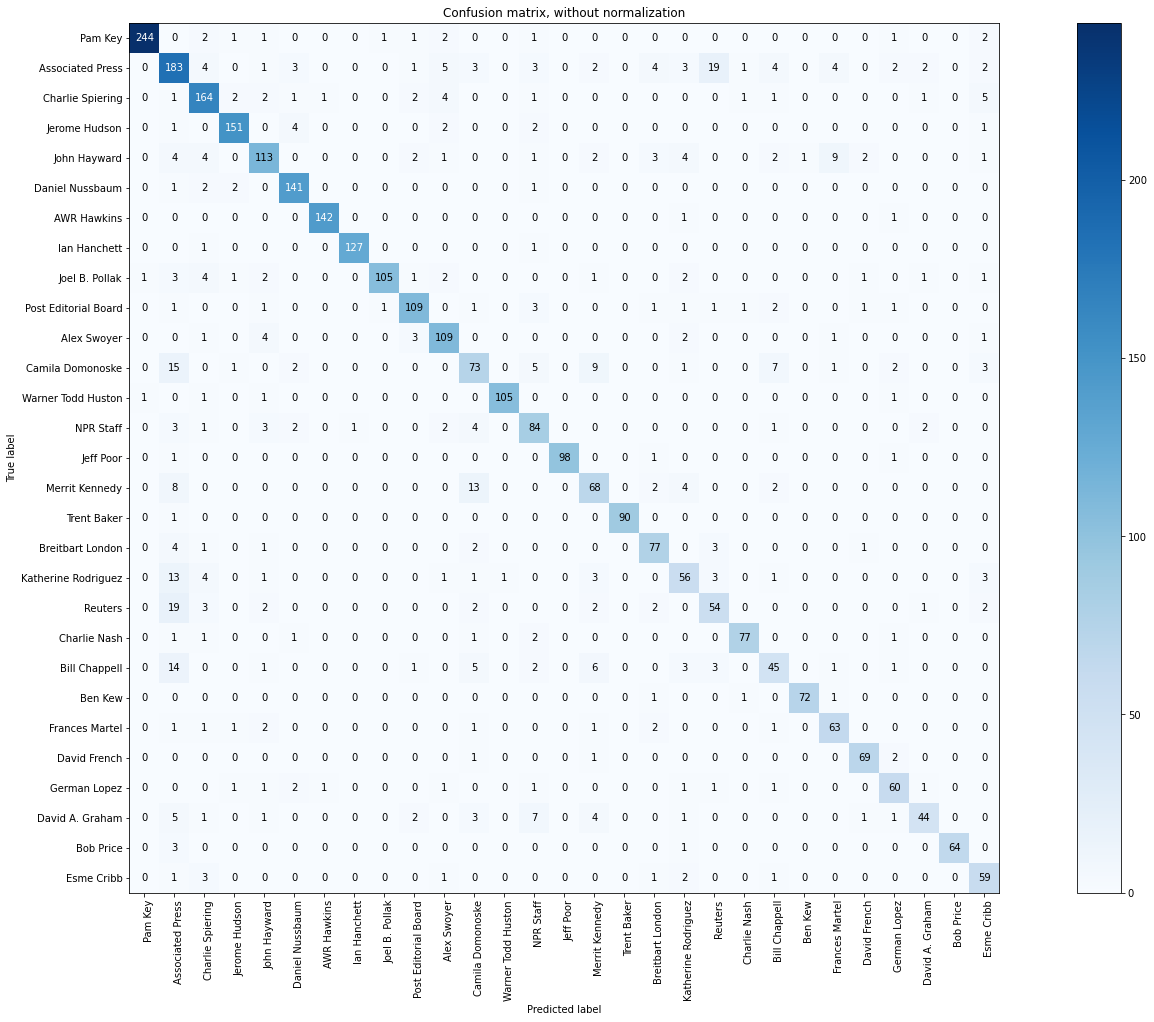

In [ ]:
y_pred = lr.predict(X_bow_tfidf_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)

> ### **(3) Classification using term frequencies (TF).**

In [ ]:
parameters = {'C': [10e-10, 0.1, 1, 10, 10e10]}
lr = GridSearchCV(LogisticRegression(class_weight='balanced', solver='lbfgs'), parameters, cv=5)
lr.fit(X_bow_counts_train, y_train)
print(lr.best_params_)

{'C': 0.1}


                      precision    recall  f1-score   support

             Pam Key       0.98      0.96      0.97       256
    Associated Press       0.67      0.71      0.69       246
    Charlie Spiering       0.79      0.89      0.84       186
       Jerome Hudson       0.96      0.97      0.97       161
        John Hayward       0.83      0.74      0.78       149
     Daniel Nussbaum       0.94      0.96      0.95       147
         AWR Hawkins       0.99      0.98      0.99       144
        Ian Hanchett       1.00      1.00      1.00       129
      Joel B. Pollak       0.91      0.85      0.88       125
Post Editorial Board       0.82      0.91      0.87       124
         Alex Swoyer       0.81      0.95      0.87       121
    Camila Domonoske       0.66      0.56      0.61       119
  Warner Todd Huston       1.00      0.98      0.99       109
           NPR Staff       0.86      0.86      0.86       103
           Jeff Poor       0.99      0.99      0.99       101
      M

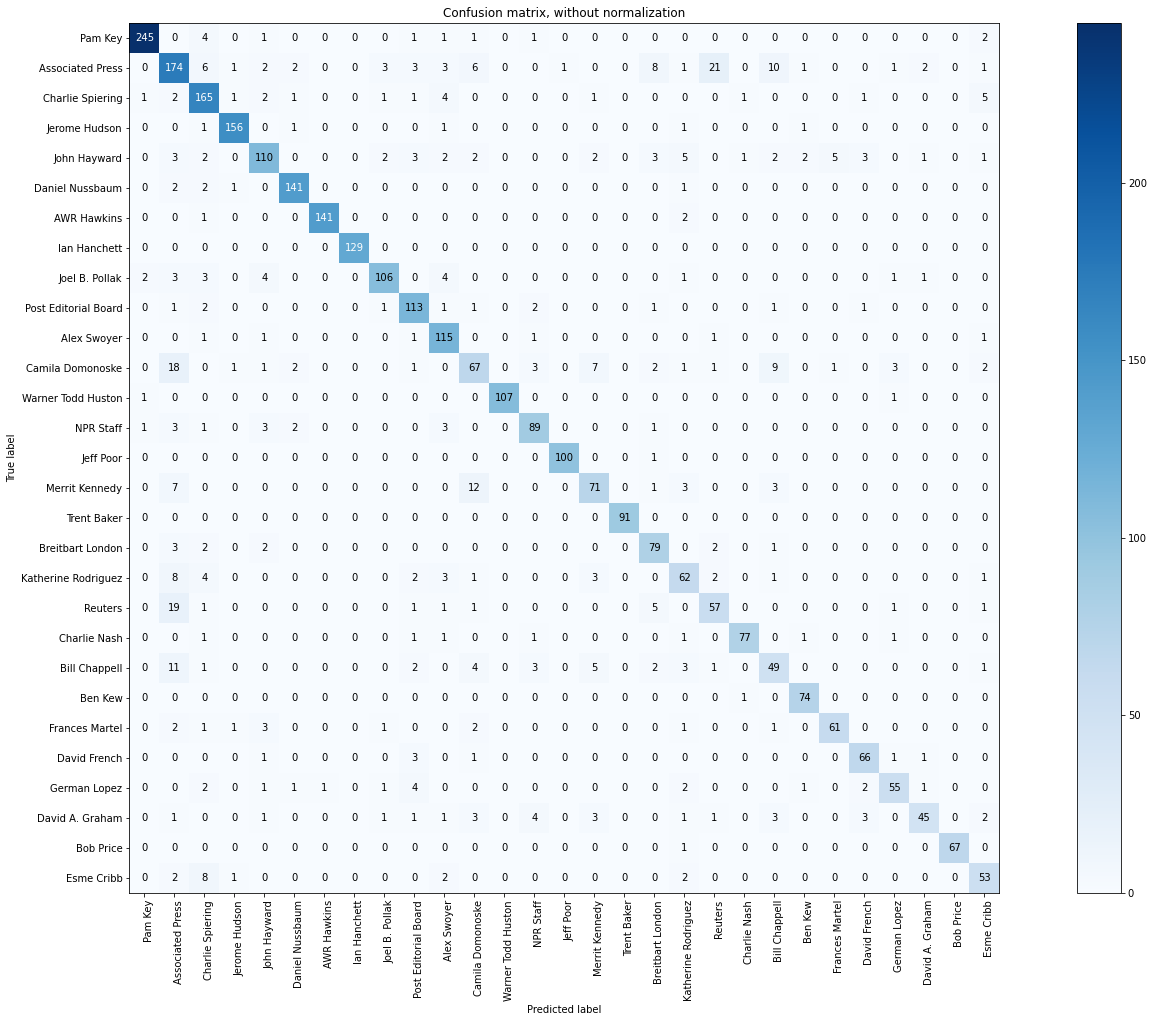

In [ ]:
y_pred = lr.predict(X_bow_counts_test)
print(classification_report(y_test, y_pred, target_names=labels))
plot_confusion_matrix(y_test, y_pred, labels)
plt.show()

### Sentiment Analysis

Now, we will perform a sentiment analysis, which is an approach to natural language processing (NLP) that identifies the emotional tone behind a body of text.
In this case, we will calculate the sentiment indicators for each article. First, we will define some functions that will allow us to get the job done.

In [78]:
# Returns four main scores on each article: Negativity, Positivity, Neutrality (from 0-1) and compound (from -1 to 1). The last one is a combination of the previous three
def sentiment(text): 
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text))

In [79]:
# Process the text in order to perform sentiment analysis
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [80]:
data['clean']=data['content'].apply(text_processing) # Apply function
data['sentiment']=data['clean'].apply(sentiment) # Apply function

In [82]:
data=data.join(data['sentiment'].apply(pd.Series)) # Split the Negativity, Positivity, Neutrality and compound scores into separated columns

C:\Users\Paulo\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='compound', ylabel='Density'>

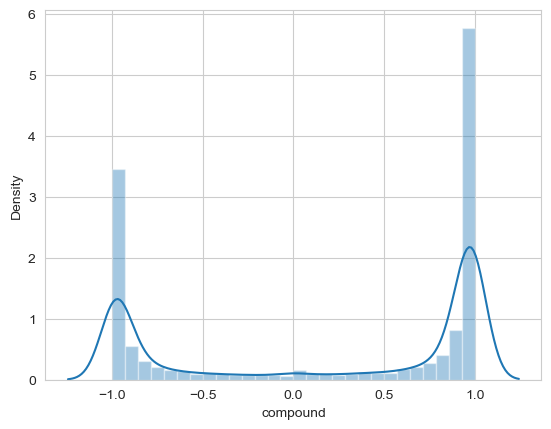

In [85]:
sns.distplot(data['compound']) #Histogram on compound values

The compound values range from -1 (most negative) to 1 (most positive).
We can see that there is really marked positive and negative trend among the articles

In [53]:
data=pd.read_csv('Articles_Sentiment.csv')

Now, we will have a look at the Top 10 happiest news titles and see if they makes sense.

In [54]:
print(data.sort_values(by='compound',ascending=False)[['title']].iloc[0:10].to_string(index=False)) #Top 10 happiest news titles

                                                                                         title
                 Donald Trump’s New York Times Interview: Full Transcript - The New York Times
                                                        Every episode of Gilmore Girls, ranked
                                Trump’s Interests vs. America’s, Trump Tower Penthouse Edition
         The Oscars always get it wrong. Here are the real Best Pictures of the past 40 years.
Donald Trump’s big press conference transcript: Annotating everything the president-elect said
                         Donald Trump’s combative, grievance-filled news conference, annotated
                         Full Transcript and Video: Trump News Conference - The New York Times
                          Inside Glossier, The Beauty Startup That Just Happens To Sell Makeup
                                              \nWill the Liberal Bubble Burst? Your Thoughts\n
                                Free Comic Book Da

As we can see, many of of them are entertainment articles, such as "Every episode of Gilmore Girls, ranked" or "The Oscars always get it wrong. Here are the real Best Pictures of the past 40 years."
This makes sense, as tipically, they don't describe any sad news or tragic event.

Now, we will hopefully dig into the saddest articles.

In [55]:
print(data.sort_values(by='compound',ascending=True)[['title']].iloc[0:10].to_string(index=False)) #Top 10 saddest news titles

                                                                                           title
          Allegations against Nate Parker have reinvigorated a push to understand sexual consent
                                                      Controversial Police Encounters Fast Facts
                                                How Much Really Changed About Terrorism on 9/11?
The justice system needs to take rape more seriously. That doesn’t mean longer prison sentences.
                            How U.S. Torture Left a Legacy of Damaged Minds - The New York Times
                         The Myth of Wanton Police Shootings Collapses under the Weight of Facts
         Terror: Truck Crashes into Crowd Celebrating Bastille Day, At Least 80 Dead - Breitbart
              Our Articles on the Attacks Trump Says the Media Didn’t Cover - The New York Times
              5 Police Officers Killed, 6 Wounded by Snipers in Dallas #BlackLivesMatter Protest
                              

Most of these stories include crimes, attacks or other tragic/violent events. This also makes sense.

Furthermore, we will visualize the most common words in happiest and saddest articles, and see if they actually have a meaning.

In [97]:
def wc(data,bgcolor,title): # Wordcloud function
    plt.figure(figsize = (100,100))
    wc = WordCloud(background_color = bgcolor, max_words = 1000,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

Extract Top 100 most positive words and plot their frequency

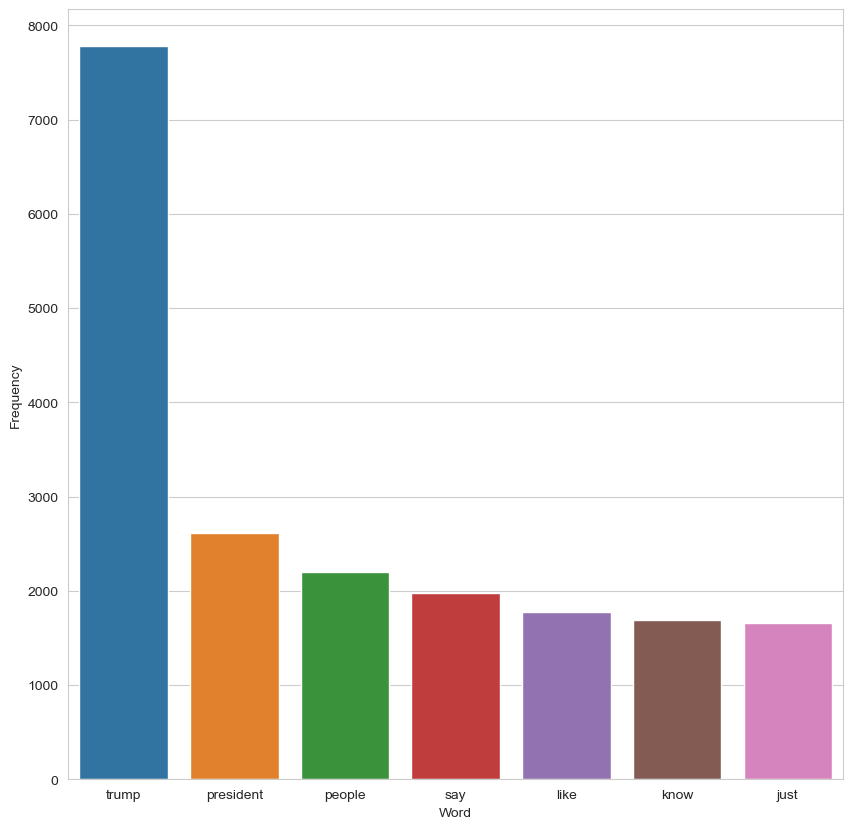

In [101]:
top_N = 100

a = data[data['compound']==1]['clean'].str.lower().str.cat(sep=' ') # Choose max compound value only

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

# Return tokens for all words
word_tokens = word_tokenize(b) 

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

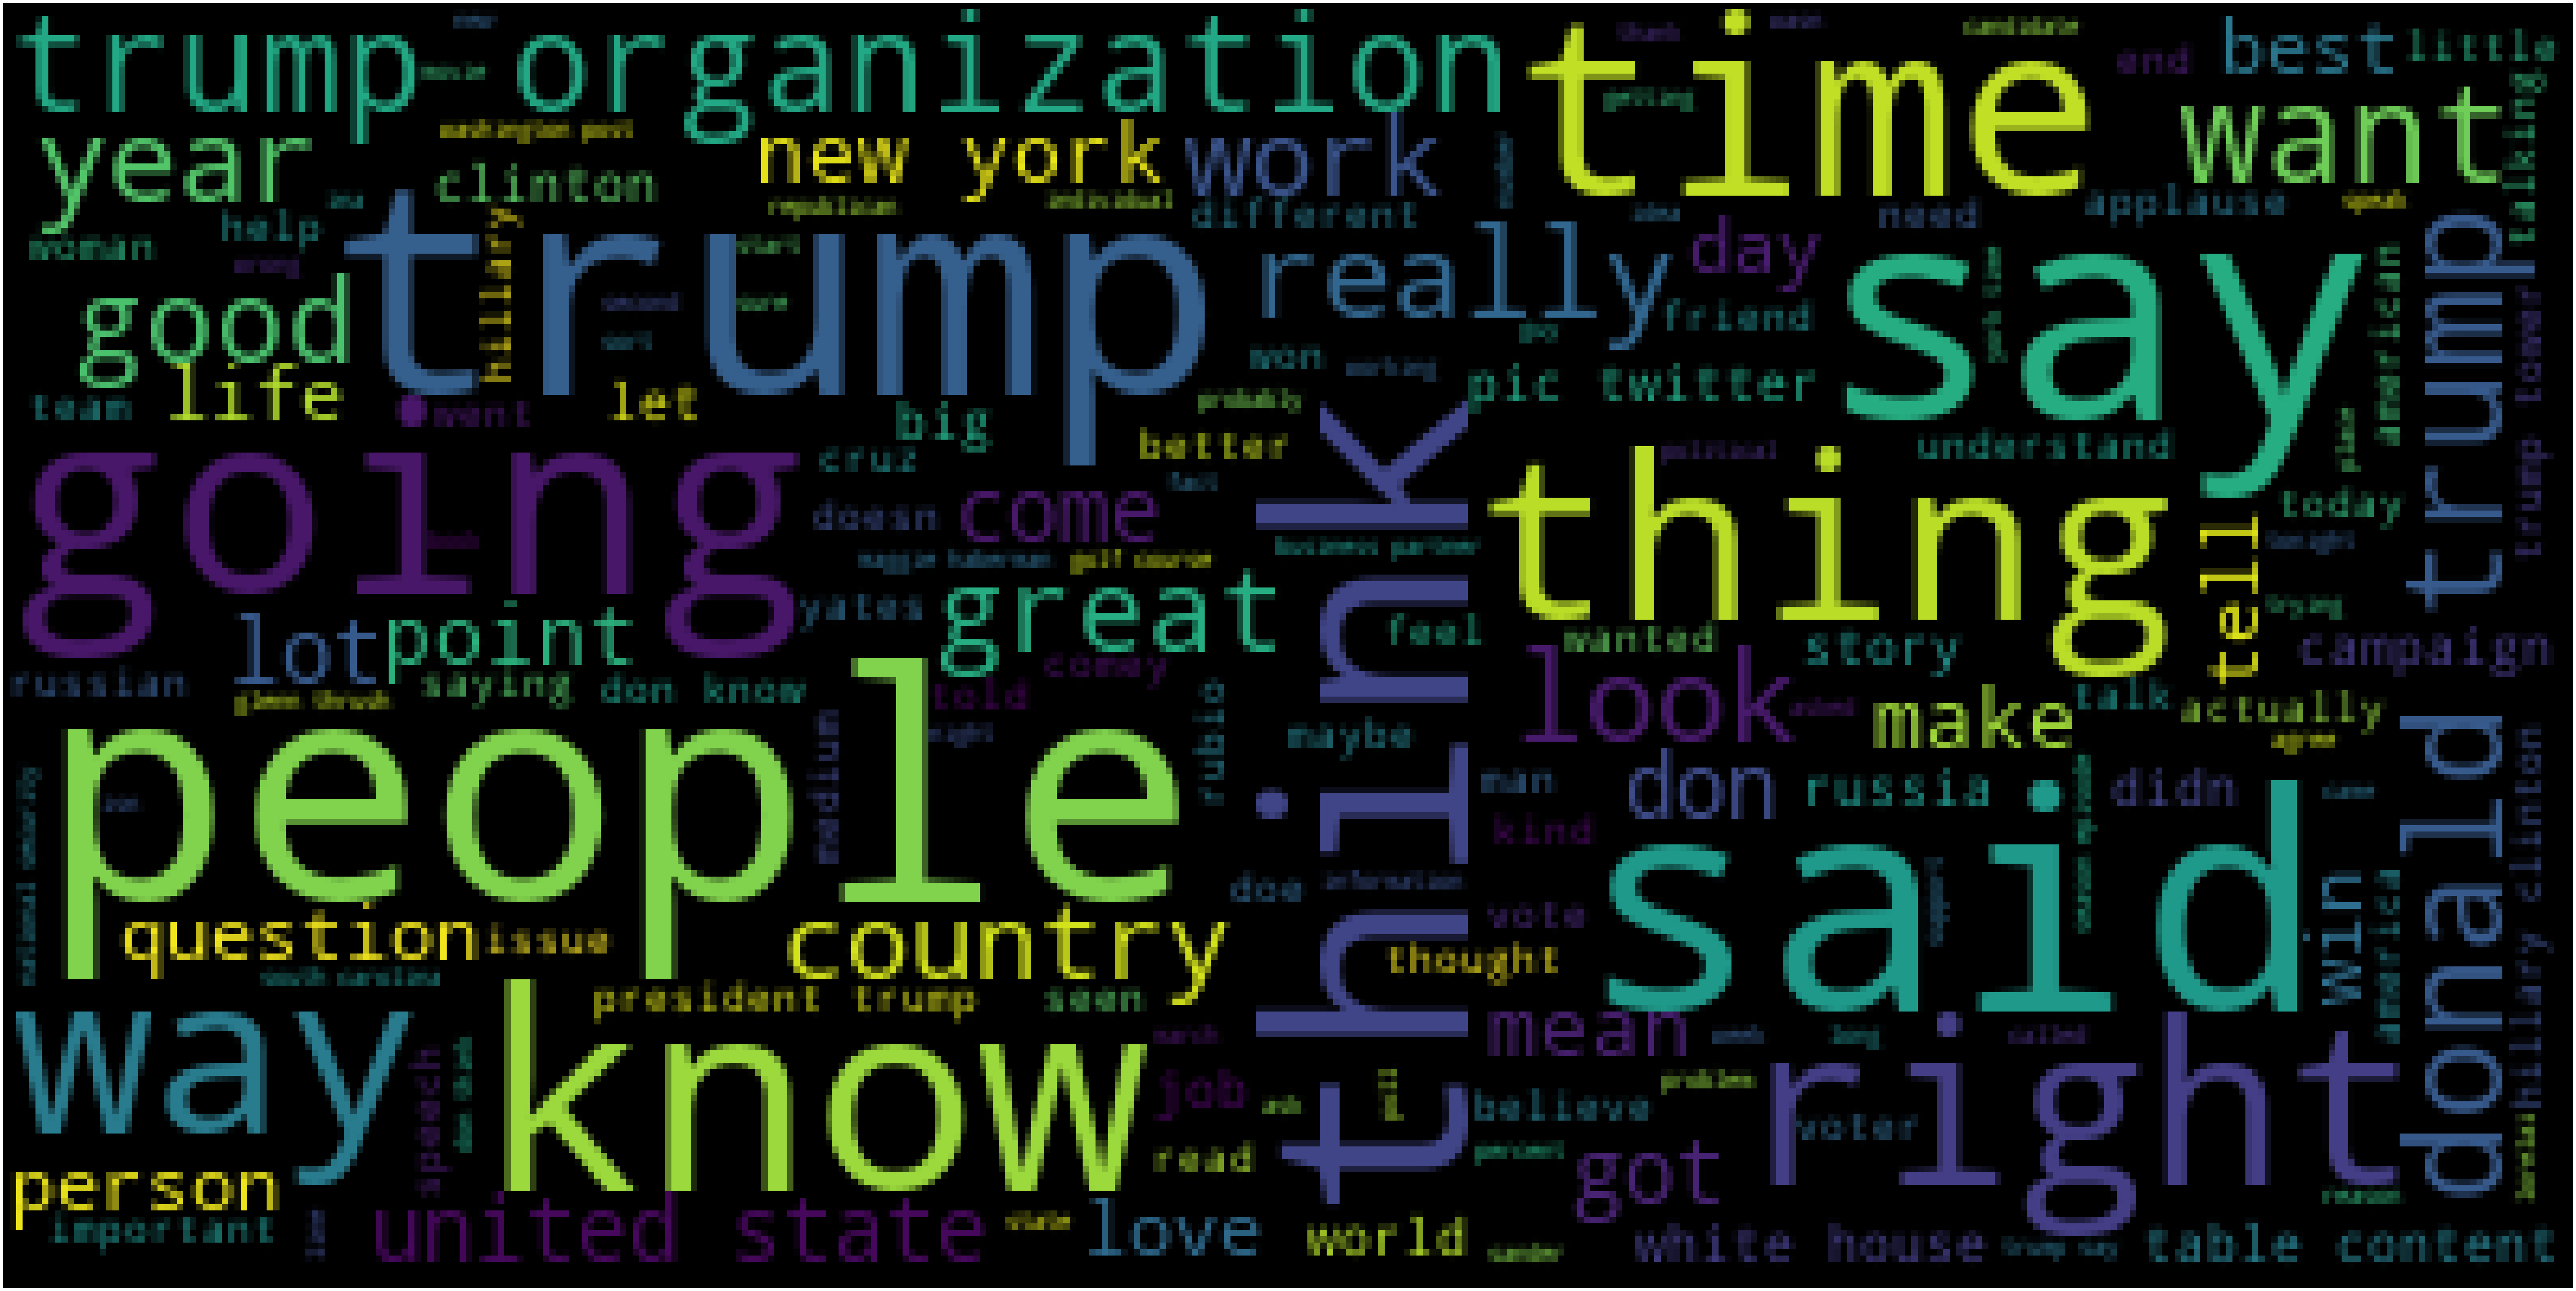

In [102]:
wc(cleaned_data_title,'black','Common Words' )

As we can see, many words are just common words, such as, "said" or "like". On the other hand, other words such as "Trump" or "president" seems to have a positive score.

We'll do the same for the Top 100 most negative words

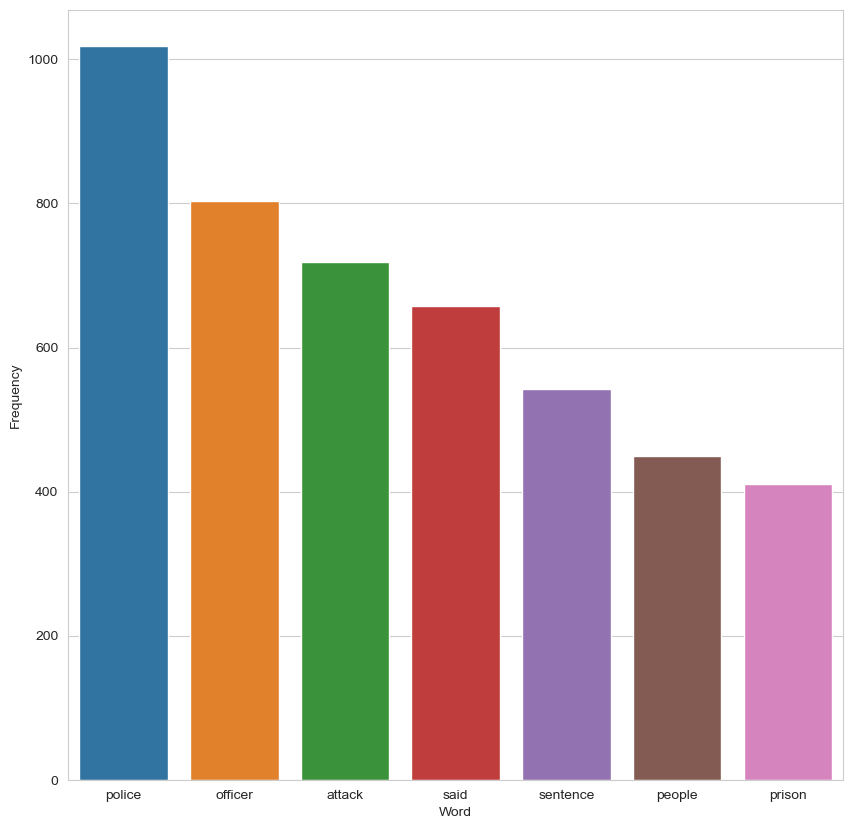

In [105]:
top_N = 100

a = data[data['compound']==-1]['clean'].str.lower().str.cat(sep=' ')

# removes punctuation,numbers and returns list of words
b = re.sub('[^A-Za-z]+', ' ', a)

word_tokens = word_tokenize(b)

# Remove characters which have length less than 2  
without_single_chr = [word for word in word_tokens if len(word) > 2]

# Remove numbers
cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        

# Calculate frequency distribution
word_dist = nltk.FreqDist(cleaned_data_title)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])

plt.figure(figsize=(10,10))
sns.set_style("whitegrid")
ax = sns.barplot(x="Word",y="Frequency", data=rslt.head(7))

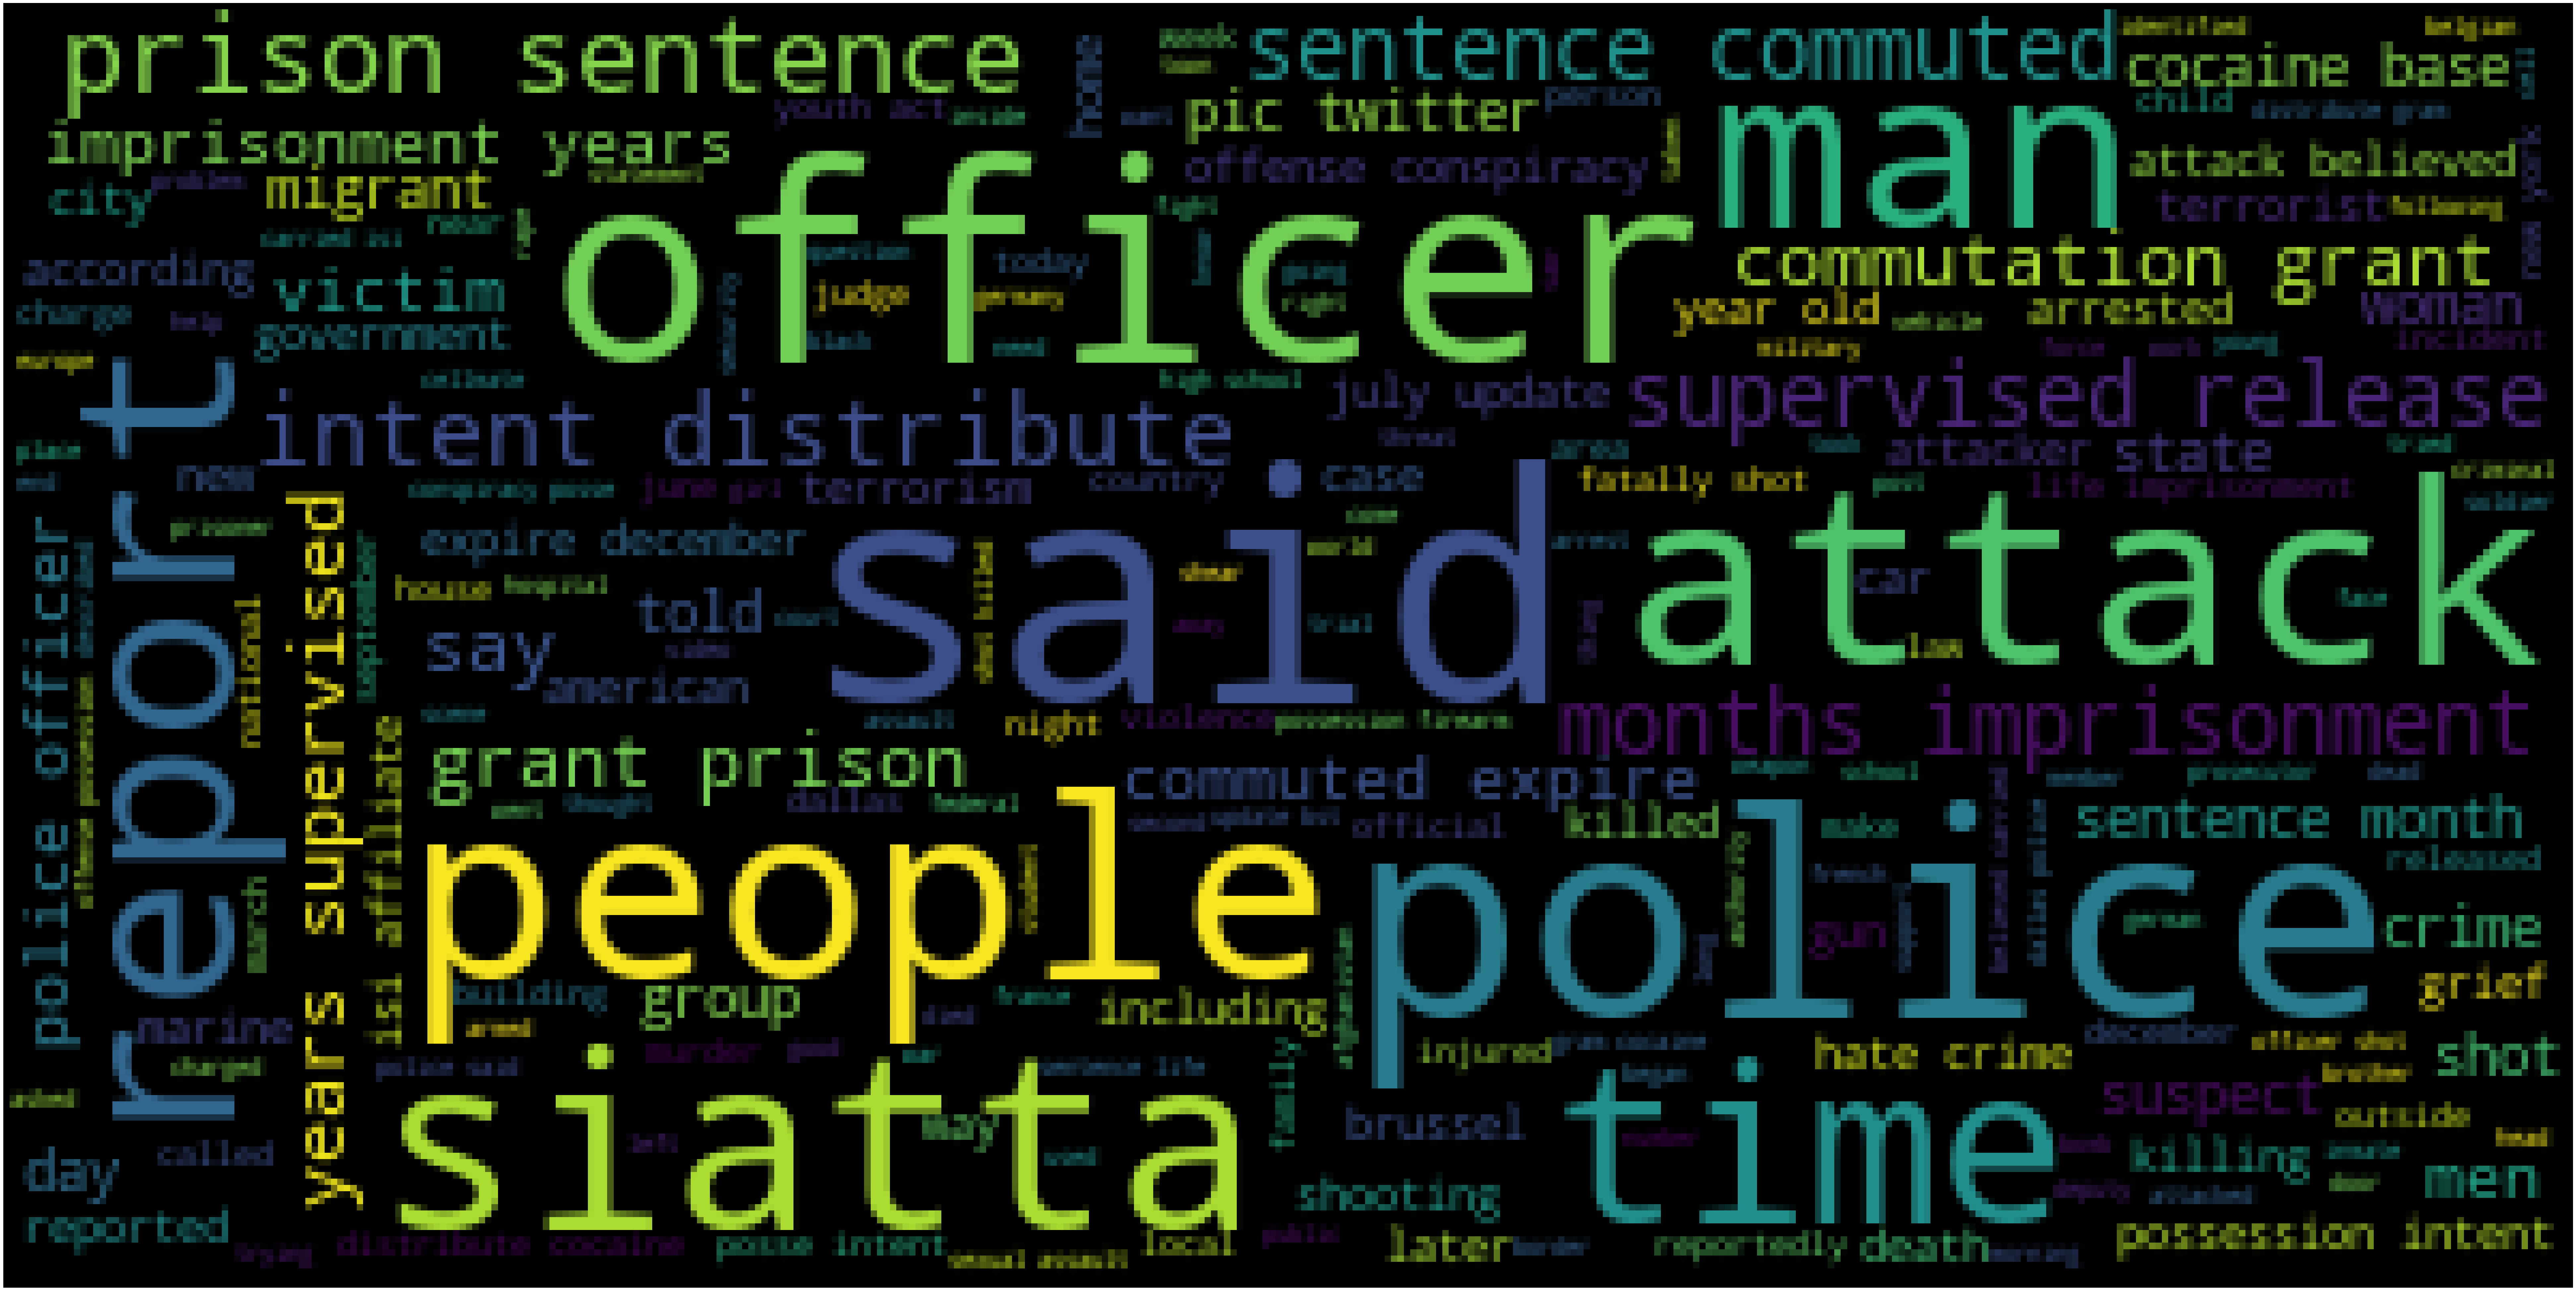

In [106]:
wc(cleaned_data_title,'black','Common Words' )

Once again, we have commond words such as "said". But most interestingly we have words such as "police" or "officer" which seems to be negative. This makes sense as most of the times they describe crime or violent articles.

### Network Analysis

We are going to create a network with the content of the article. More specifically, we'll extract the top 10 most repeated words for each media outlet, and build a network that unites them.
We would like to know if the publications tend to use same words in their articles.

We'll define some functions that will help us to achieve this.

In [9]:
# Function that extract the top 10 most frequent word for each article
def top10(b):
    top_N=10
    word_tokens = word_tokenize(b)
    filtered_sentence = word_tokens
    # Remove characters which have length less than 2  
    without_single_chr = [word for word in filtered_sentence if len(word) > 2]
    # Remove numbers
    cleaned_data_title = [word for word in without_single_chr if not word.isnumeric()]        
    # Calculate frequency distribution
    word_dist = nltk.FreqDist(cleaned_data_title)
    rslt = dict(word_dist.most_common(top_N))
    rslt.update((key, value * (1/len(word_tokens))) for key, value in rslt.items())
    return rslt # Return words and their relative frequency

In [42]:
#Create graph for given data
def create_graph(grouping):
    grouping['top10']=grouping['clean'].apply(top10) # Extract top 10 words
    grouping=grouping.join(grouping['top10'].apply(pd.Series), lsuffix='_', rsuffix=' ') # Create columns for each words
    G=nx.DiGraph() # initialize graph
    for index,row in grouping.iterrows(): 
        G.add_node(index,world='publication') # Add node for each publication
    for word in grouping.columns[5:]: 
        G.add_node(word,world='word') # Add node for each unique word
    for index,rows in grouping.iterrows():
        for column in grouping.columns[5:]:
            if not pd.isna(rows[column]):
                G.add_edge(index,column,freq=rows[column]) # Add edge for each publication and node
    pos=nx.spiral_layout(G,resolution=0.6) # set up the graph
    print ("This network has %s nodes and %s edges" %(G.number_of_nodes(), G.number_of_edges())) # Details for the graph
    nx.draw(G,pos, with_labels=True,width=0.6)
    plt.show()

Now, we'll wrap up article content by year month and publication for further analysis.

In [43]:
data['clean']=data['clean'].astype(str)
group=data.dropna(subset=['year','month'])
group=data.groupby(['year','month','publication'], as_index = False).agg({'clean': ' '.join})
group['year'],group['month']=group['year'].astype(int),group['month'].astype(int)

We will now generate graphs for several months in 2017 as an example. Each node with numbers corresponds to a media outlet (NY Times, Washington Post, etc).


Each edge or link from a media outlet to a certain word is only present if that word is among the top 10 words for all articles in that outlet in that month.


The maximum number of nodes possible for each network is 165 (15 media outlet + 150 top 10 words).

Graph for Month No. 1 of 2017.
This network has 46 nodes and 140 edges


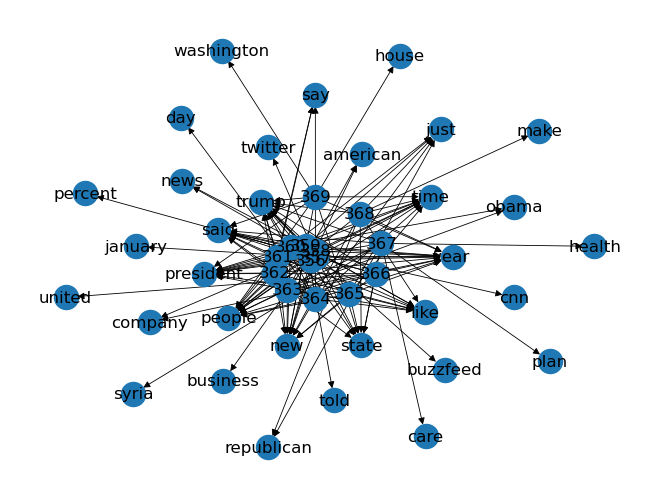

Graph for Month No. 2 of 2017.
This network has 48 nodes and 140 edges


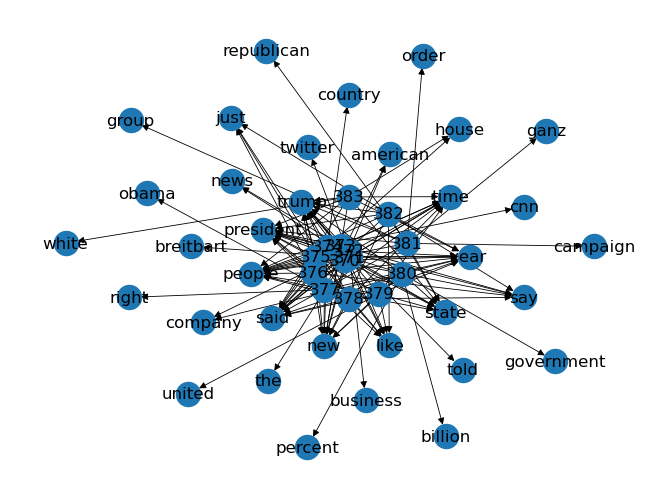

Graph for Month No. 3 of 2017.
This network has 43 nodes and 140 edges


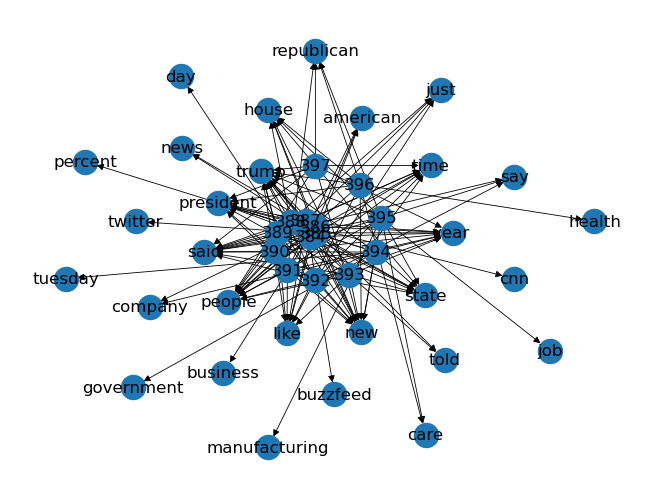

Graph for Month No. 4 of 2017.
This network has 43 nodes and 140 edges


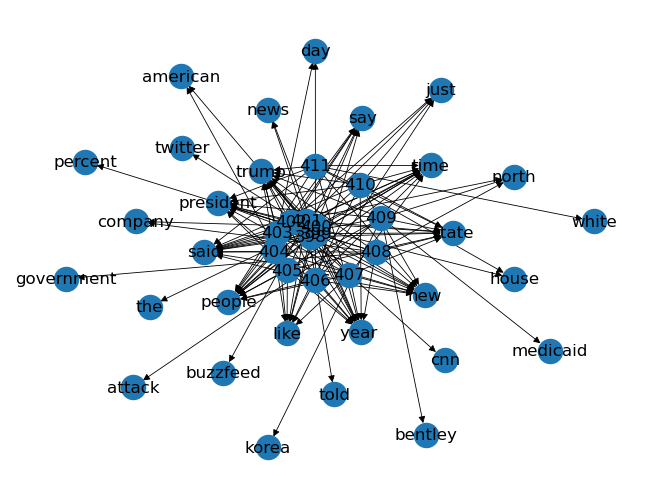

Graph for Month No. 5 of 2017.
This network has 45 nodes and 120 edges


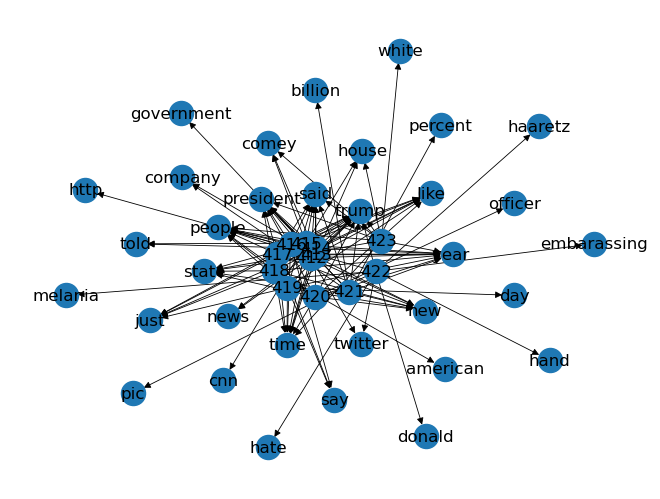

Graph for Month No. 6 of 2017.
This network has 68 nodes and 130 edges


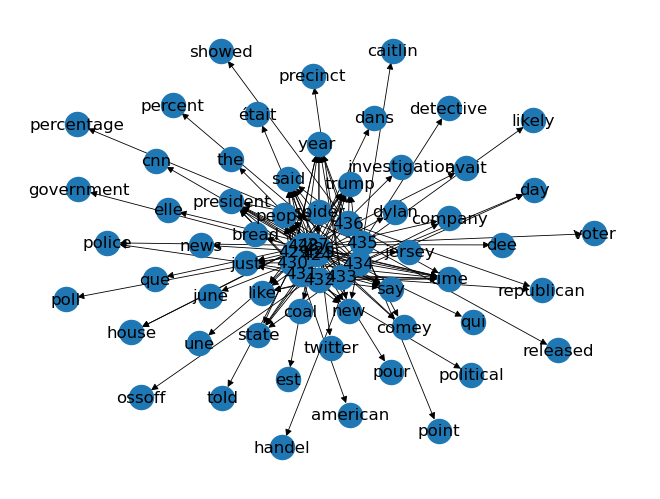

In [44]:
for i in range (1,7):    
    print("Graph for Month No. %s of 2017."%i)
    create_graph(group.loc[(group['year']==2017) & (group['month']==i)])

As we can see, most of the times the number of edges is much lower than 165, which means that media outlets tend to use the same words. 

This makes sense as they write about common topics most of the times. For example, words such as "people", "trump", "republican" come up as common words since President Trump was taking office in the beggining of 2017.

# Author Prediction on Sentiment

Once again, we will load the data, and perform the sentiment analysis for the top 30 authors.

In [35]:
data=pd.read_csv('Top30.csv',index_col=0) # Read top30 media outlet articles

In [27]:
def sentiment(text):
    sia = SentimentIntensityAnalyzer()
    return(sia.polarity_scores(text))

In [28]:
def text_processing(text,lemmatizing=True,stop=True):
    # remove punctuation 
    text = "".join([c for c in text 
                    if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    if stop:
        text = " ".join([w for w in text.split() 
                         if w not in Stop_Words])
    if lemmatizing:
        # stemming / lematizing (optional)
        text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [ ]:
data['clean']=data['content'].apply(text_processing) # Apply text processing
data['sentiment']=data['clean'].apply(sentiment) # Extract sentiment indicators
data = data.join(data['sentiment'].apply(pd.Series)) # Distribuite indicators in columns
data['lenght']=data['content'].str.len() # Calculate lenght article

In [42]:
data=pd.read_csv('Articles_Sentiment_top30.csv')

### Now, we will try to predict the authors article by the value of each sentiment analysis indicator: Positivity, Negativity and Neutrality.

<AxesSubplot:xlabel='neg', ylabel='pos'>

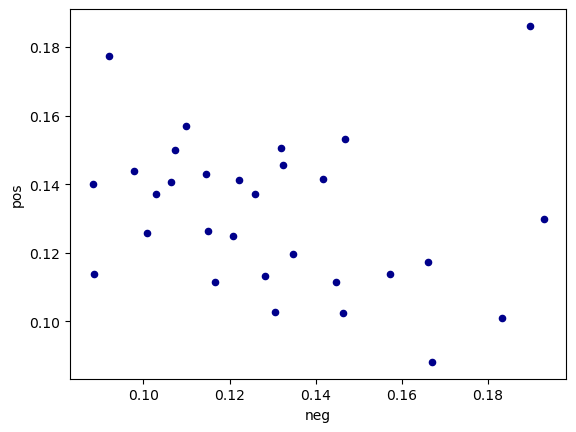

In [43]:
#For the sake of visualization, we will plot the mean value of positivity and negativity of each author.
data.groupby('author').mean().plot.scatter(x='neg',y='pos',c='DarkBlue')

At least for these two indicators, authors seems to be really close to each other, so at a first glance, we can say it's going to be hard to predict the author based on the sentiment.

In [44]:
# Make a DataFrame with articles by our chosen authors. Include author names and article titles.
# Make a list of the 30 chosen author names
names = data.author.value_counts()[data.author.value_counts()>100][-30:].index.tolist()
# DataFrame for articles of all chosen authors
authors_data = pd.DataFrame()
for name in names:
    # Select each author's data
    articles = data[data.author==name][:100]
    # Append it to the DataFrame
    authors_data = authors_data.append(articles)
authors_data = authors_data.reset_index().drop('index',1)

In [45]:
authors_data['new_id'] = pd.factorize(authors_data['author'])[0] # Transform author's name into unique number to compare with cluster later on
authors_df=authors_data.drop_duplicates(subset='new_id')[['author','new_id']]  # Unique author df

In [46]:
# Establish outcome and predictors
y = authors_data['new_id'] # Each author ID 
X = authors_data[['pos','neg','neu']] # Sentiment indicators
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.24,random_state=0,stratify=y) # Split train and test dataset

In [47]:
# Create dataframe which will store the results
metrics = ['Algorithm','n_train','Features','ARI','Homogeneity',
           'Mutual_Info','Test_Accuracy','Cross_Val','Train_Accuracy']
performance = pd.DataFrame(columns=metrics)

In [48]:
# Function to quickly evaluate clustering solutions
def evaluate_clust(clust,params,features,i,authors_df=authors_df):
    t0 = time()
    print('\n','-'*40,'\n',clust.__class__.__name__,'\n','-'*40)
    
    # Find best parameters based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust,params,scoring=score,cv=3).fit(X_train,y_train)
    print("Best parameters:",search.best_params_) # Search best parameter for the method
    y_pred = search.best_estimator_.fit_predict(X_test)
    
    # Calculate Accuracy by authour
    y_test2=y_test.copy() # Copy of the test dataframe
    y_test2['prediction']=0 # Initialize column
    y_test2=y_test2.reset_index()
    for number,predic in enumerate(y_pred):
        y_test2.loc[number,'prediction']=int(predic) # Add prediction for later comparison
    y_test2.dropna(subset='prediction',inplace=True)
    y_test2['prediction']=y_test2['prediction'].astype(int)
    y_test2['match']=np.where(y_test2['prediction']==y_test2['new_id'],1,0) # Count matches for each author
    y_test2=y_test2[['new_id','match']]
    accuracy_by_author=y_test2.groupby('new_id').sum().reset_index()
    authors_df=authors_df.merge(accuracy_by_author,on='new_id')
    name='accuracy_'+str(clust)[:-2]+'_Sentiment'
    authors_df[name]=authors_df['match']/24 # Calculate Accuracy
    del authors_df['match']
    
    # Calculate Clustering Indicators
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i,'ARI'] = ari 
    print("Adjusted Rand-Index: %.3f" % ari)
    
    hom = homogeneity_score(y_test,y_pred)
    performance.loc[i,'Homogeneity'] = hom
    print("Homogeneity Score: %.3f" % hom)
    
    acc = accuracy_score(y_test, y_pred)
    performance.loc[i,'Test_Accuracy'] = acc
    print("Test Accuracy Score: %.3f" % acc)
    
    nmi = normalized_mutual_info_score(y_test,y_pred)
    performance.loc[i,'Mutual_Info'] = nmi
    print("Normed Mutual-Info Score: %.3f" % nmi)
    
    performance.loc[i,'n_train'] = len(X_train)
    performance.loc[i,'Features'] = features
    performance.loc[i,'Algorithm'] = clust.__class__.__name__
    
    # Print contingency matrix
    crosstab = pd.crosstab(y_test, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0,"seconds.")
    return authors_df

We will try several clustering algorithms to predict the author.


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best parameters: {'init': 'k-means++', 'n_clusters': 30, 'n_init': 20}
Adjusted Rand-Index: 0.012
Homogeneity Score: 0.220
Test Accuracy Score: 0.042
Normed Mutual-Info Score: 0.224


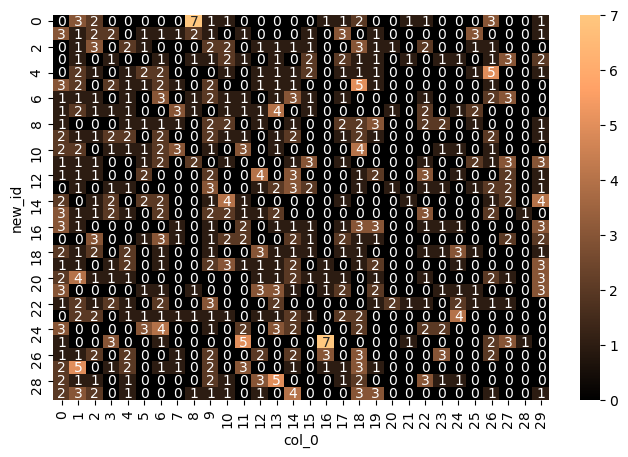

67.10688352584839 seconds.


In [154]:
clust=KMeans()
params={
    'n_clusters': np.arange(10,35,5),
    'init': ['k-means++','random'],
    'n_init':[10,20],
    #'precompute_distances':[True,False]
}
authors_df=evaluate_clust(clust,params,features='Sentiment',i=0,authors_df=authors_df)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best parameters: {}
Adjusted Rand-Index: 0.000
Homogeneity Score: 0.000
Test Accuracy Score: 0.033
Normed Mutual-Info Score: 0.000


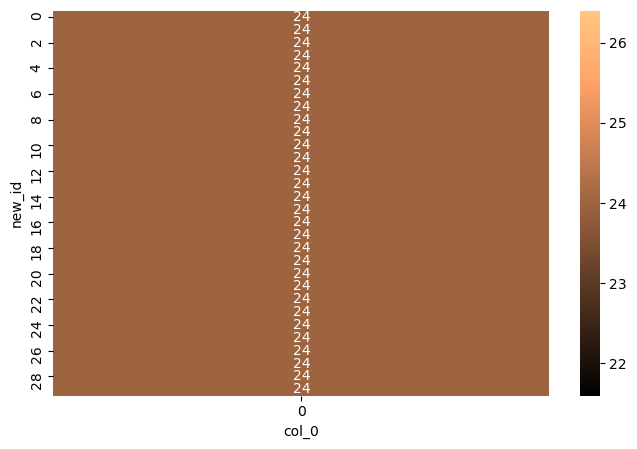

40.00981163978577 seconds.


In [155]:
#Declare and fit the model
clust = MeanShift()
params={}
authors_df=evaluate_clust(clust,params,features='Sentiment',i=1,authors_df=authors_df)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best parameters: {'damping': 0.5, 'max_iter': 200}
Adjusted Rand-Index: 0.015
Homogeneity Score: 0.223
Test Accuracy Score: 0.028
Normed Mutual-Info Score: 0.227


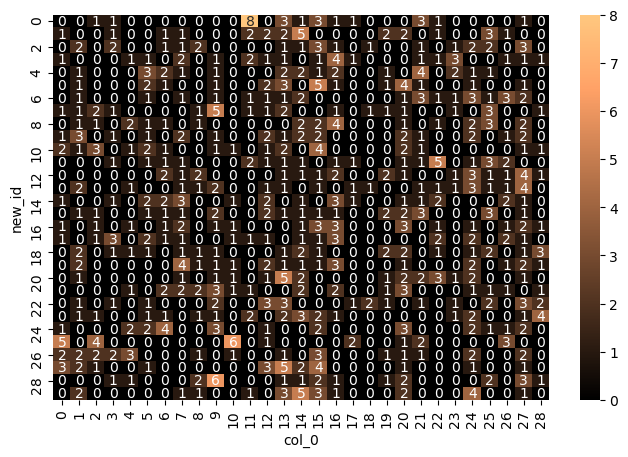

1521.8403322696686 seconds.


In [156]:
#Declare and fit the model.
clust = AffinityPropagation()
params = {
    'damping':[.5,.7,.9],
    'max_iter':[200,500]
}
authors_df=evaluate_clust(clust,params,features='Sentiment',i=2,authors_df=authors_df)

Adjusted Rand-Index: 0.007
Homogeneity Score: 0.037
Normed Mutual-Info Score: 0.054


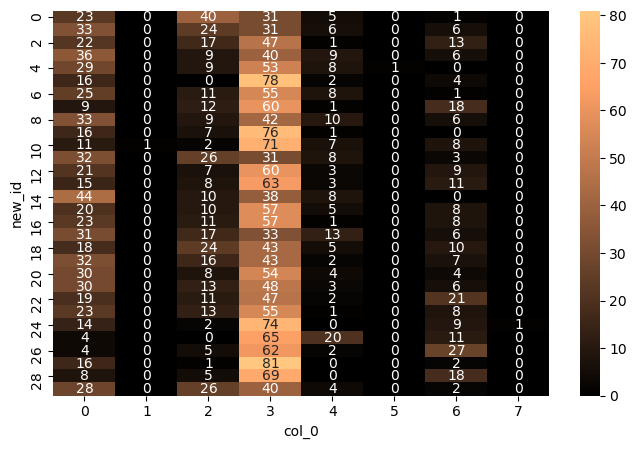

62.453396797180176 seconds.


In [49]:
clust= SpectralClustering()

params = {
    'n_clusters':np.arange(10,35,5),
    'n_init':[15,25],
    'assign_labels':['kmeans','discretize']
}

features='Sentiment'

i=3

t0=time()
#Predict the author
y_pred = clust.fit_predict(X)

#Accuracy by author
y_test2=y.copy()
y_test2['prediction']=0
y_test2=y_test2.reset_index()

for number,predic in enumerate(y_pred):
    y_test2.loc[number,'prediction']=int(predic)
y_test2.dropna(subset='prediction',inplace=True)
y_test2['prediction']=y_test2['prediction'].astype(int)
y_test2['match']=np.where(y_test2['prediction']==y_test2['new_id'],1,0)
y_test2=y_test2[['new_id','match']]
accuracy_by_author=y_test2.groupby('new_id').sum().reset_index()
authors_df=authors_df.merge(accuracy_by_author,on='new_id')
name='accuracy_'+str(clust)[:-2]+'_Sentiment'
authors_df[name]=authors_df['match']/100
del authors_df['match']


#Clustering indicators
ari = adjusted_rand_score(y, y_pred)
performance.loc[i,'ARI'] = ari 
print("Adjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(y,y_pred)
performance.loc[i,'Homogeneity'] = hom
print("Homogeneity Score: %.3f" % hom)

nmi = normalized_mutual_info_score(y,y_pred)
performance.loc[i,'Mutual_Info'] = nmi
print("Normed Mutual-Info Score: %.3f" % nmi)

performance.loc[i,'n_train'] = len(X)
performance.loc[i,'Features'] = features
performance.loc[i,'Algorithm'] = clust.__class__.__name__

# Print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True,fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0,"seconds.")

In [160]:
authors_df.to_csv('Accuracy_by_author.csv')

In [159]:
performance.iloc[:,:7]

,Algorithm,n_train,Features,ARI,Homogeneity,Mutual_Info,Test_Accuracy
0,KMeans,2280,Sentiment,0.012277,0.220228,0.224012,0.041667
1,MeanShift,2280,Sentiment,0.0,0.0,0.0,0.033333
2,AffinityPropagation,2280,Sentiment,0.015266,0.222908,0.227336,0.027778
3,SpectralClustering,3000,Sentiment,0.006894,0.036893,0.053699,NaN


As we suspected in the beggining, the accuracy is really poor, as the article sentiment varies on the topic and not only by the author. 

# Neural Network

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
data = pd.read_csv('top30.csv')
data['lenght']=data['content'].apply(len)
data=data.sort_values(by='lenght',ascending=False)[4:]
names = data.author.value_counts().index.tolist()
minarticles = data.author[data.author == names[-1]].value_counts()
names.remove('Breitbart News')

In [ ]:
# # Make a DataFrame with articles by our chosen authors
# # Include author names and article titles.

# # Make a list of the 10 chosen author names
# names = data.author.value_counts()[data.author.value_counts()>100][-30:].index.tolist()

# # DataFrame for articles of all chosen authors
# authors_data = pd.DataFrame()
# for name in names:
#     # Select each author's data
#     articles = data[data.author==name][:minarticles[0]][['title','content','author']]
#     # Append it to the DataFrame
#     authors_data = authors_data.append(articles)
# authors_data = authors_data.reset_index().drop('index',1)
    
# authors_data.head()

In [ ]:
# # Look for duplicates
# print('Number of articles:',authors_data.shape[0])
# print('Unique articles:',len(np.unique(authors_data.index)))

# # Number of authors
# print('Unique authors:',len(np.unique(authors_data.author)))
# print('')
# print('Articles by author:\n')

# # Articles counts by author
# print(authors_data.author.value_counts())

In [ ]:
# #!{sys.executable} -m spacy download en
# t0 = time()

# # Load spacy NLP object
# nlp = spacy.load("en_core_web_sm")
# nlp.max_length = 3000000
# # A list to store common words by all authors
# common_words = []

# # A dictionary to store the spacy_doc object of each author
# authors_docs = {}

# for name in names:
#     # Corpus is all the text written by that author
#     corpus = ""
#     # Grab all rows of current author, along the 'content' column
#     author_content = authors_data.loc[authors_data.author==name,'content']
    
#     # Merge all articles in to the author's corpus
#     for article in author_content:
#         corpus = corpus + article
#     # Let Spacy parse the author's body of text
#     doc = nlp(corpus)
    
#     # Store the doc in the dictionary
#     authors_docs[name] = doc
        
#     # Filter out punctuation and stop words.
#     lemmas = [token.lemma_ for token in doc
#                 if not token.is_punct and not token.is_stop]
        
#     # Return the most common words of that author's corpus.
#     bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
#     # Add them to the list of words by all authors.
#     for word in bow:
#         common_words.append(word)

# # Eliminate duplicates
# common_words = set(common_words)
    
# print('Total number of common words:',len(common_words))
# print("done in %0.3fs" % (time() - t0))

In [ ]:
# # Let's see our 10 authors in the dictionary
# lengths = []
# for k,v in authors_docs.items():
#     print(k,'corpus contains',len(v),' words.')
#     lengths.append(len(v))



In [ ]:
# # check for lower case words
# common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
# print('Count of all common_words:',len(common_words))
# print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# # Turn all common_words into lower case
# common_words = [word.lower() for word in common_words]
# print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))


# # We must remove these in to avoid conflicts with existing features.
# if 'author' in common_words:
#     common_words.remove('author')
# if 'title' in common_words:
#     common_words.remove('title')
# if 'content' in common_words:
#     common_words.remove('content')

In [ ]:
# # Count the number of times a common_word appears in each article
# # (about 3Hrs processing)

# bow_counts = pd.DataFrame()
# for name in names:
#     # Select X articles of that author
#     articles = authors_data.loc[authors_data.author==name,:]
#     bow_counts = bow_counts.append(articles)
# bow_counts = bow_counts.reset_index().drop('index',1)

# # Use common_words as the columns of a temporary DataFrame
# df = pd.DataFrame(columns=common_words)

# # Join BOW features with the author's content
# bow_counts = bow_counts.join(df)

# # Initialize rows with zeroes
# bow_counts = bow_counts.loc[:,~bow_counts.columns.duplicated()].copy()
# bow_counts.loc[:,common_words] = 0

# # Fill the DataFrame with counts of each feature in each article
# t0 = time()
# for i, article in enumerate(bow_counts.content):
#     doc = nlp(article)
#     for token in doc:
#         if token.lemma_.lower() in common_words:
#             bow_counts.loc[i,token.lemma_.lower()] += 1
#     # Print a message every X articles
#     if i % 50 == 0:
#         if time()-t0 < 3600: # if less than an hour in seconds
#             print("Article ",i," done after ",(time()-t0)/60,' minutes.')
#         else:
#             print("Article ",i," done after ",(time()-t0)/60/60,' hours.')

In [ ]:
# This saves the long-awaited data into a pickle file for easy recovery
#bow_counts.to_pickle('bow_counts338')
# Read it back in with the following
bow_counts = pd.read_pickle('bow_counts338')

In [ ]:
y = bow_counts['author']
counter = 0
newy = np.zeros(len(y))
last = y[0]
for i in range(len(y)):
    if y[i] != last:
        counter+=1
    newy[i] = counter
    last = y[i]
X = bow_counts.drop(['content','author','title'], 1)
X = X.loc[:,~X.columns.duplicated()].copy()
X = X.to_numpy()
N, M = X.shape
import torch.nn as nn
#X = scipy.stats.zscore(X)
n_hidden_units = 2     # number of hidden units
n_replicates = 1        # number of networks trained in each k-fold
max_iter = 10000         # stop criterion 2 (max epochs in training)


class Net(nn.Module):
    def __init__(self,D_in,H,H2,H3,D_out):
        super(Net,self).__init__()
        self.linear1=nn.Linear(D_in,H)
        self.linear2=nn.Linear(H,H2)
        #self.linear3=nn.Linear(H2,D_out)
        self.linear3=nn.Linear(H2,H3)
        self.linear4=nn.Linear(H3,D_out)
        
    def forward(self,x):
        x=F.relu(self.linear1(x))
        x=F.relu(self.linear2(x))
        x=F.relu(self.linear3(x))  
        #x=self.linear3(x)
        x=self.linear4(x)
        return x
#model=Net(M,300,150,30)
loss_fn = torch.nn.CrossEntropyLoss()

C:\Users\penna\AppData\Local\Temp\ipykernel_13012\1546452035.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = bow_counts.drop(['content','author','title'], 1)


In [ ]:
batch_size=128
k=10
splits=KFold(n_splits=k,shuffle=True)

In [ ]:
#dataset = np.column_stack((X,newy))
X = X.astype('float32')
class Data(Dataset):
    def __init__(self):
        self.x=torch.from_numpy(X)
        self.y=torch.from_numpy(newy)
        self.len=self.x.shape[0]
    def __getitem__(self,index):      
        return self.x[index], self.y[index]
    def __len__(self):
        return self.len
dataset=Data()

In [ ]:
def train_epoch(model,device,dataloader,loss_fn,optimizer):
    train_loss,train_correct=0.0,0
    model.train()
    #for images, labels in dataloader:
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output,labels.long())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss,train_correct
  
def valid_epoch(model,device,dataloader,loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for inputs, labels in dataloader:

        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        loss=loss_fn(output,labels.long())
        valid_loss+=loss.item()*inputs.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct+=(predictions == labels).sum().item()
    return valid_loss,val_correct

In [ ]:
H1 = round(math.sqrt(M * 30))
H2 = round(H1/2)
H3 = round(H2/2)
foldperf={'fold1': {}, 'fold2': {}, 'fold3': {}, 'fold4': {}, 'fold5': {}, 'fold6': {},'fold7': {},'fold8': {}, 'fold9': {}, 'fold10': {}}
num_epochs=20
learning_rates = [0.00001, 0.00002, 0.00003, 0.00004, 0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001]
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for learning_rate in learning_rates:
        model = Net(M,H1,H2,H3,30)
        model.to(device)
        #learning_rate=0.000085
        #optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        #lrdict = {}
        history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
    
        for epoch in range(num_epochs):
            train_loss, train_correct=train_epoch(model,device,train_loader,loss_fn,optimizer)
            test_loss, test_correct=valid_epoch(model,device,test_loader,loss_fn)
    
            train_loss = train_loss / len(train_loader.sampler)
            train_acc = train_correct / len(train_loader.sampler) * 100
            test_loss = test_loss / len(test_loader.sampler)
            test_acc = test_correct / len(test_loader.sampler) * 100
    
            print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                                 num_epochs,
                                                                                                                 train_loss,
                                                                                                                 test_loss,
                                                                                                                 train_acc,
                                                                                                                 test_acc))
            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)
        #lrdict['lr{}'.format(learning_rate)] = history
        foldperf['fold{}'.format(fold+1)]['lr{}'.format(learning_rate)] = history#['lr{}'.format(learning_rate)] = history

Fold 1
Epoch:1/20 AVG Training Loss:3.402 AVG Test Loss:3.396 AVG Training Acc 3.96 % AVG Test Acc 5.20 %
Epoch:2/20 AVG Training Loss:3.389 AVG Test Loss:3.384 AVG Training Acc 6.03 % AVG Test Acc 6.73 %
Epoch:3/20 AVG Training Loss:3.373 AVG Test Loss:3.369 AVG Training Acc 7.10 % AVG Test Acc 6.32 %
Epoch:4/20 AVG Training Loss:3.353 AVG Test Loss:3.349 AVG Training Acc 7.60 % AVG Test Acc 6.01 %
Epoch:5/20 AVG Training Loss:3.327 AVG Test Loss:3.322 AVG Training Acc 7.38 % AVG Test Acc 5.30 %
Epoch:6/20 AVG Training Loss:3.294 AVG Test Loss:3.289 AVG Training Acc 8.11 % AVG Test Acc 7.75 %
Epoch:7/20 AVG Training Loss:3.253 AVG Test Loss:3.248 AVG Training Acc 11.90 % AVG Test Acc 11.82 %
Epoch:8/20 AVG Training Loss:3.202 AVG Test Loss:3.198 AVG Training Acc 18.56 % AVG Test Acc 17.23 %
Epoch:9/20 AVG Training Loss:3.143 AVG Test Loss:3.141 AVG Training Acc 22.81 % AVG Test Acc 22.43 %
Epoch:10/20 AVG Training Loss:3.077 AVG Test Loss:3.082 AVG Training Acc 27.91 % AVG Test Acc 27

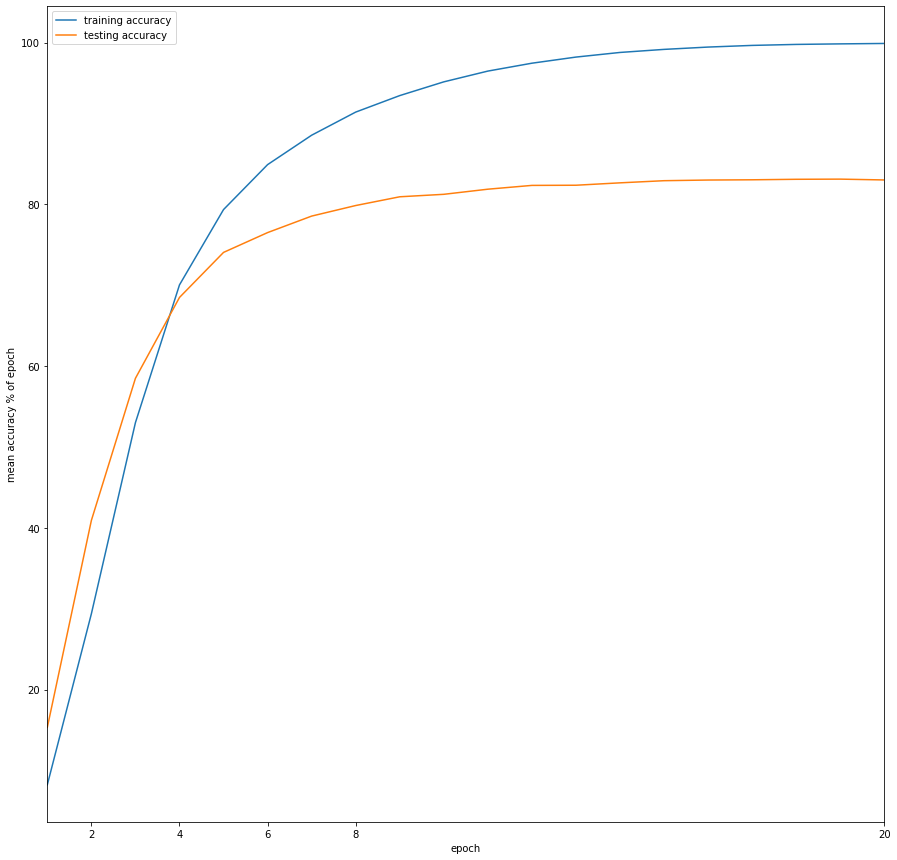

In [ ]:
learning_rates

[1e-05, 2e-05, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 9e-05, 0.0001]

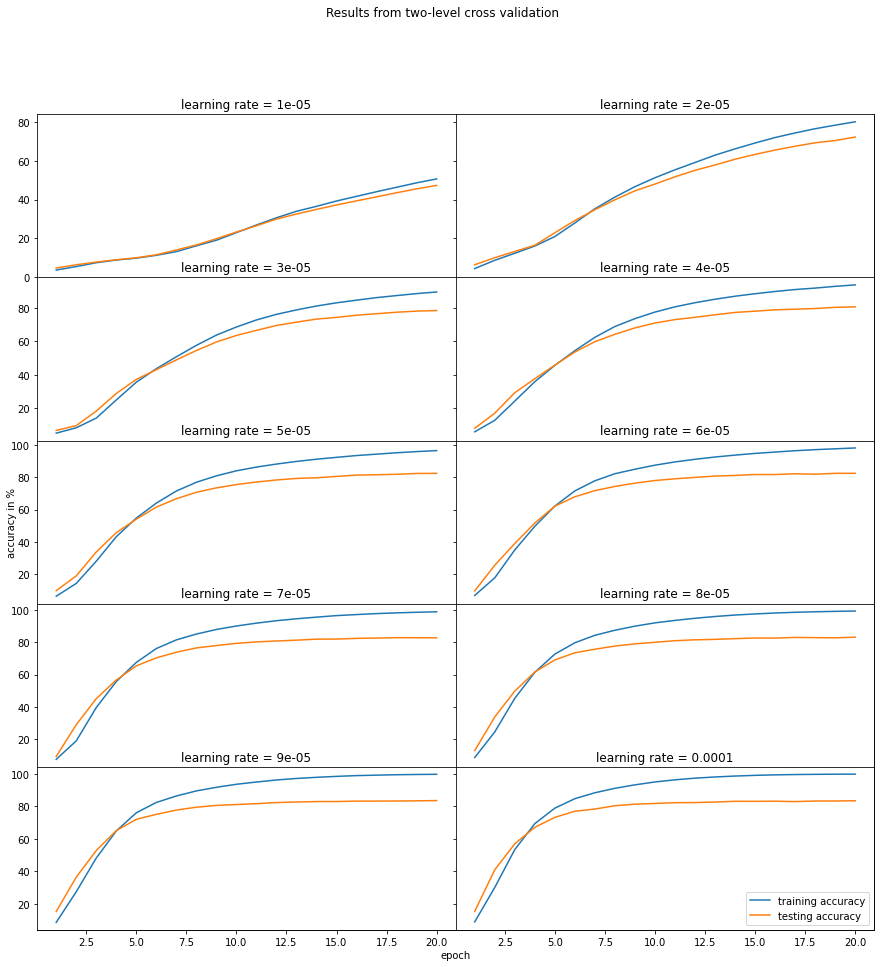

In [ ]:
trainacc = [[],[],[],[],[],[],[],[],[],[]]
testacc = [[],[],[],[],[],[],[],[],[],[]]
for j in range(num_epochs):
    for x in range(len(learning_rates)):
        testsums = []
        trainsums = []
        for i in range(1,k+1):
            testsums.append(foldperf['fold'+str(i)]['lr'+str(learning_rates[x])]['test_acc'][j])
            trainsums.append(foldperf['fold'+str(i)]['lr'+str(learning_rates[x])]['train_acc'][j])
        trainacc[x].append(np.mean(trainsums))
        testacc[x].append(np.mean(testsums))

# plt.figure(figsize=(15,15))
# plt.plot(np.arange(1,num_epochs+1), trainacc, label='training accuracy')
# plt.plot(np.arange(1,num_epochs+1), testacc, label='testing accuracy')
# plt.ylabel('mean accuracy % of epoch')
# plt.xlabel('epoch')
# plt.xticks([0,2,4,6,8,num_epochs])
# plt.legend()
# plt.xlim((1,num_epochs))
# plt.show()
x = np.arange(1, num_epochs+1)
fig = plt.figure(figsize=(15,15))
plt.xlabel('epoch', labelpad=20)
plt.ylabel('accuracy in %', labelpad=20)
plt.xticks([])
plt.yticks([])
gs = fig.add_gridspec(5, 2, hspace=0, wspace=0)
(ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10) = gs.subplots(sharex='col', sharey='row')
fig.suptitle('Results from two-level cross validation')
ax1.plot(x, trainacc[0], label = 'training accuracy')
ax1.plot(x, testacc[0], label = 'testing accuracy')
ax1.set_title('learning rate = '+str(learning_rates[0]))
ax2.plot(x, trainacc[1], label = 'training accuracy')
ax2.plot(x, testacc[1], label = 'testing accuracy')
ax2.set_title('learning rate = '+str(learning_rates[1]))
ax3.plot(x, trainacc[2], label = 'training accuracy')
ax3.plot(x, testacc[2], label = 'testing accuracy')
ax3.set_title('learning rate = '+str(learning_rates[2]))
ax4.plot(x, trainacc[3], label = 'training accuracy')
ax4.plot(x, testacc[3], label = 'testing accuracy')
ax4.set_title('learning rate = '+str(learning_rates[3]))
ax5.plot(x, trainacc[4], label = 'training accuracy')
ax5.plot(x, testacc[4], label = 'testing accuracy')
ax5.set_title('learning rate = '+ str(learning_rates[4]))
ax6.plot(x, trainacc[5], label = 'training accuracy')
ax6.plot(x, testacc[5], label = 'testing accuracy')
ax6.set_title('learning rate = '+ str(learning_rates[5]))
ax7.plot(x, trainacc[6], label = 'training accuracy')
ax7.plot(x, testacc[6], label = 'testing accuracy')
ax7.set_title('learning rate = '+ str(learning_rates[6]))
ax8.plot(x, trainacc[7], label = 'training accuracy')
ax8.plot(x, testacc[7], label = 'testing accuracy')
ax8.set_title('learning rate = '+ str(learning_rates[7]))
ax9.plot(x, trainacc[8], label = 'training accuracy')
ax9.plot(x, testacc[8], label = 'testing accuracy')
ax9.set_title('learning rate = '+ str(learning_rates[8]))
ax10.plot(x, trainacc[9], label = 'training accuracy')
ax10.plot(x, testacc[9], label = 'testing accuracy')
ax10.set_title('learning rate = '+ str(learning_rates[9]))
plt.legend()

for ax in fig.get_axes():
    ax.label_outer()

In [ ]:
H1 = round(math.sqrt(M * 30))
H2 = round(H1/2)
H3 = round(H2/2)
foldperf={}
num_epochs=20
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
    test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = Net(M,H1,H2,H3,30)
    model.to(device)
    learning_rate=0.00009
    #optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in range(num_epochs):
        train_loss, train_correct=train_epoch(model,device,train_loader,loss_fn,optimizer)
        test_loss, test_correct=valid_epoch(model,device,test_loader,loss_fn)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} AVG Training Loss:{:.3f} AVG Test Loss:{:.3f} AVG Training Acc {:.2f} % AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)
    #lrdict['lr{}'.format(learning_rate)] = history
        foldperf['fold{}'.format(fold+1)] = history#['lr{}'.format(learning_rate)] = history

Fold 1
Epoch:1/20 AVG Training Loss:3.349 AVG Test Loss:3.245 AVG Training Acc 9.73 % AVG Test Acc 17.23 %
Epoch:2/20 AVG Training Loss:2.966 AVG Test Loss:2.690 AVG Training Acc 26.49 % AVG Test Acc 37.51 %
Epoch:3/20 AVG Training Loss:2.303 AVG Test Loss:2.067 AVG Training Acc 47.91 % AVG Test Acc 53.41 %
Epoch:4/20 AVG Training Loss:1.720 AVG Test Loss:1.649 AVG Training Acc 66.04 % AVG Test Acc 63.20 %
Epoch:5/20 AVG Training Loss:1.309 AVG Test Loss:1.359 AVG Training Acc 76.79 % AVG Test Acc 70.23 %
Epoch:6/20 AVG Training Loss:1.011 AVG Test Loss:1.160 AVG Training Acc 82.64 % AVG Test Acc 75.54 %
Epoch:7/20 AVG Training Loss:0.784 AVG Test Loss:1.015 AVG Training Acc 87.11 % AVG Test Acc 77.57 %
Epoch:8/20 AVG Training Loss:0.619 AVG Test Loss:0.924 AVG Training Acc 89.81 % AVG Test Acc 78.19 %
Epoch:9/20 AVG Training Loss:0.493 AVG Test Loss:0.861 AVG Training Acc 92.39 % AVG Test Acc 78.49 %
Epoch:10/20 AVG Training Loss:0.401 AVG Test Loss:0.805 AVG Training Acc 94.29 % AVG 

In [ ]:
def accuracyEachClass(model,device,dataloader):
    classes = np.arange(0,29)
    classes = list(classes)
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    for inputs, labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        output = model(inputs)
        scores, predictions = torch.max(output.data,1)
        for label, prediction in zip(labels, predictions):
            label = int(label)
            if label == prediction:
                correct_pred[int(classes[label])] += 1
            total_pred[int(classes[label])] += 1
    return correct_pred, total_pred

cor,tot = accuracyEachClass(model,device,test_loader)

# print accuracy for each class
for classname, correct_count in cor.items():
    accuracy = 100 * float(correct_count) / tot[classname]
    print(f'Accuracy for class: {names[classname]:25s} is {accuracy:.1f} %')

Accuracy for class: Pam Key                   is 93.8 %
Accuracy for class: Associated Press          is 54.8 %
Accuracy for class: Charlie Spiering          is 73.0 %
Accuracy for class: Jerome Hudson             is 82.8 %
Accuracy for class: John Hayward              is 73.5 %
Accuracy for class: Daniel Nussbaum           is 89.5 %
Accuracy for class: AWR Hawkins               is 100.0 %
Accuracy for class: Ian Hanchett              is 93.8 %
Accuracy for class: Joel B. Pollak            is 87.2 %
Accuracy for class: Post Editorial Board      is 92.9 %
Accuracy for class: Alex Swoyer               is 84.6 %
Accuracy for class: Camila Domonoske          is 54.3 %
Accuracy for class: Warner Todd Huston        is 92.6 %
Accuracy for class: NPR Staff                 is 94.9 %
Accuracy for class: Jeff Poor                 is 93.1 %
Accuracy for class: Merrit Kennedy            is 62.9 %
Accuracy for class: Trent Baker               is 97.3 %
Accuracy for class: Breitbart London          i

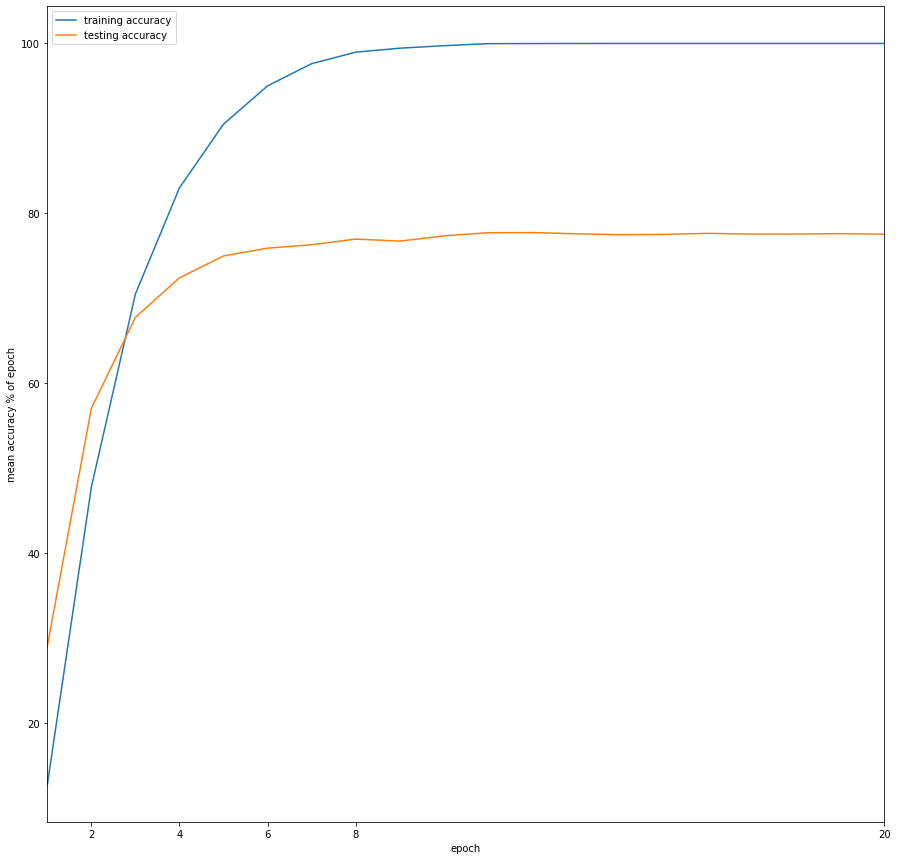

In [ ]:
# trainacc = []
# testacc = []
# for j in range(num_epochs):
#     testsums = []
#     trainsums = []
#     for i in range(1,k+1):
#         testsums.append(foldperf['fold'+str(i)]['test_acc'][j])
#         trainsums.append(foldperf['fold'+str(i)]['train_acc'][j])
#     trainacc.append(np.mean(trainsums))
#     testacc.append(np.mean(testsums))
# plt.figure(figsize=(15,15))
# plt.plot(np.arange(1,num_epochs+1), trainacc, label='training accuracy')
# plt.plot(np.arange(1,num_epochs+1), testacc, label='testing accuracy')
# plt.ylabel('mean accuracy % of epoch')
# plt.xlabel('epoch')
# plt.xticks([0,2,4,6,8,num_epochs])
# plt.legend()
# plt.xlim((1,num_epochs))
# plt.show()